# Implémentation et exploitation d’un problème de tournée sous contraintes
## Projet – Groupe 4 : Mathéo Pinget, Alban Calvo, Evan Joasson


# Génération des instances de problèmes (Datasets)

Dans cette section, nous générons aléatoirement des instances de problèmes avec des pondérations aléatoires représentant les coûts des routes.
Il permet également de simuler des routes en travaux (inutilisables) et de visualiser le graphe.  

Ces instances sont adaptées à notre problème et permettent une évaluation réaliste de nos algorithmes de résolution.


Nous utilisons :

- **NetworkX** pour la manipulation des graphes,

- **NumPy** pour la gestion des matrices,

- **Matplotlib** pour l'affichage visuel.

In [1]:
# Importation des bibliothèques nécessaires
import networkx as nx        # Manipulation de graphes
import numpy as np           # Création et gestion de matrices
import random                # Génération aléatoire de données
import matplotlib.pyplot as plt  # Affichage graphique
import pandas as pd #export csv
import os #export csv

In [2]:
# Fonction pour générer une matrice d'adjacence pondérée et l'ordre des villes à traverser
def generer_matrice_avec_ordre(n_sommets, cout_max=10, taux_travaux=0.2):
    # Création d'une matrice vide de taille n_sommets x n_sommets, initialisée à 0
    matrice = np.zeros((n_sommets, n_sommets), dtype=int)
    
    # Étape 1 : Génération d’un arbre couvrant pour garantir la connexité du graphe
    sommets = list(range(n_sommets))
    random.shuffle(sommets)  # Mélange des sommets pour créer des arêtes aléatoires
    
    # Création de l'arbre couvrant (cela garantit la connexité du graphe)
    for i in range(n_sommets - 1):
        a, b = sommets[i], sommets[i + 1]  # Sélection aléatoire de deux sommets à connecter
        cout = random.randint(1, cout_max)  # Génération aléatoire du coût pour cette arête
        matrice[a][b] = cout  # Ajout de l'arête dans la matrice d'adjacence
        matrice[b][a] = cout  # La matrice est symétrique pour un graphe non orienté
    
    # Étape 2 : Compléter la matrice pour obtenir un graphe complet
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):  # Nous parcourons uniquement les éléments au-dessus de la diagonale
            if matrice[i][j] == 0:  # Si l'arête n'existe pas encore (valeur 0)
                if random.random() < taux_travaux:  # Si un taux de travail est rencontré, rendre l'arête inutilisable
                    val = -1  # Route en travaux
                else:
                    val = random.randint(1, cout_max)  # Génération d'un coût aléatoire pour une route praticable
                matrice[i][j] = val  # Ajout de l'arête dans la matrice
                matrice[j][i] = val  # La matrice est symétrique pour un graphe non orienté
    
    np.fill_diagonal(matrice, 0)  # On ne laisse aucune boucle (i.e., une arête reliant un sommet à lui-même)
    
    # Étape 3 : Ordonnancement aléatoire des villes à traverser
    villes_a_ordonner = random.sample(range(n_sommets), k=2)  # Sélection d'un sous-ensemble de villes à ordonnancer
    ordre = random.sample(villes_a_ordonner, len(villes_a_ordonner))  # Ordre de passage aléatoire
    
    # Ajout 1 à chaque ville pour que l'ordre commence à 1
    ordre = [v + 1 for v in ordre]
    
    print(f"Points collectes: {ordre}")
    
    # Modification des coûts pour refléter l'ordonnancement
    for i in range(len(ordre) - 1):
        a, b = ordre[i], ordre[i + 1]  # Connexion entre les villes dans l'ordre
        matrice[a - 1][b - 1] += 10  # Augmentation du coût pour l'ordre de passage
        matrice[b - 1][a - 1] += 10  # Assurer la symétrie

    # Étape 4 : Vérification de la connexité du graphe
    G = nx.Graph()  # Création d'un objet graphe vide avec NetworkX
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):  # On parcourt toutes les paires de sommets
            if matrice[i][j] > 0:  # Seules les arêtes avec un coût positif sont ajoutées
                G.add_edge(i, j)  # Ajout de l'arête au graphe

    # Si le graphe n'est pas connexe, on ajoute des arêtes pour le rendre connexe
    if not nx.is_connected(G):  # Vérification de la connexité
        composants = list(nx.connected_components(G))  # Identification des composants connexes
        for k in range(len(composants) - 1):  # Si plusieurs composants existent, les relier
            u = random.choice(list(composants[k]))  # Choisir un sommet de chaque composant
            v = random.choice(list(composants[k + 1]))
            cout = random.randint(1, cout_max)  # Générer un coût pour l'arête
            matrice[u][v] = cout  # Ajouter l'arête au graphe
            matrice[v][u] = cout  # Assurer la symétrie

    return matrice, ordre  # Retourner la matrice d'adjacence et l'ordre des villes

## Fonction : `generer_matrice_avec_ordre`

Cette fonction génère une **matrice d’adjacence** représentant un graphe **connexe et complet**, avec :
- Un **arbre couvrant** pour assurer la connexité
- Un **remplissage aléatoire** pour obtenir la complétude
- Un **taux de routes en travaux** (valeur `-1`)
- Un **points de collectes** aléatoire

Elle garantit que toutes les paires de sommets sont connectées, même si certaines routes sont inutilisables (en travaux).


In [3]:
# Fonction pour afficher la matrice d'adjacence sous forme de liste lisible
def afficher_matrice_liste(matrice):
    # Affichage lisible de la matrice sous forme de liste de listes
    print("[")
    for ligne in matrice:
        print("    " + str(list(map(int, ligne))) + ",")
    print("]")

## Fonction : `afficher_matrice_liste`

Cette fonction affiche la matrice d’adjacence sous la forme d’une **liste de listes**.
Cela permet une lecture plus claire qu’un simple affichage brut avec NumPy.


In [4]:
# Fonction pour afficher le graphe sous forme de visualisation
def afficher_graphe(matrice):
    G = nx.Graph()  # Création d'un graphe vide
    
    n_sommets = len(matrice)  # Nombre de sommets dans la matrice
    
    # Ajout des arêtes au graphe en fonction de la matrice d'adjacence
    for i in range(n_sommets):
        for j in range(i + 1, n_sommets):
            poids = matrice[i][j]  # Poids de l'arête entre les sommets i et j
            if poids != 0:  # On ignore les arêtes ayant un poids de 0 (diagonales)
                # Ajout de l'arête avec l'attribut 'travaux' pour savoir si l'arête est en travaux
                G.add_edge(i + 1, j + 1, weight=poids, travaux=(poids == -1))

    # Positionnement des sommets de manière automatique
    pos = nx.spring_layout(G, seed=42)
    
    # Définition des couleurs des arêtes : rouge pour les routes en travaux, gris pour les autres
    edge_colors = ['red' if G[u][v]['travaux'] else 'gray' for u, v in G.edges()]
    
    # Préparation des étiquettes des arêtes (affichage des poids sauf pour les routes en travaux)
    edge_labels = {
        (u, v): ('' if G[u][v]['travaux'] else G[u][v]['weight']) for u, v in G.edges()
    }

    # Affichage du graphe avec Matplotlib
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos, with_labels=True, node_color='skyblue', node_size=600,
        edge_color=edge_colors, width=2, font_weight='bold'
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    plt.title("Graphe Complet – Routes praticables (gris), en travaux (rouge)")
    plt.show()

## Fonction : `afficher_graphe`

Cette fonction convertit la matrice d’adjacence en un graphe `NetworkX` et l'affiche visuellement avec `Matplotlib`.

- Les **routes praticables** (coût > 0) sont en **gris** avec leur poids.
- Les **routes en travaux** (coût = -1) sont en **rouge**, sans étiquette de poids.


In [5]:
# Fonction pour exporter la matrice et l'ordre des villes au format CSV
def exporter_csv(matrice, ordre, nom_fichier="matrice_routes_ordre_generation_aleatoire.csv"):
    chemin_fichier = os.path.join("data", nom_fichier)  # Définition du chemin d'exportation
    
    # Création du DataFrame pour la matrice d'adjacence
    df_matrice = pd.DataFrame(matrice)
    
    # Création du DataFrame pour l'ordre des villes
    df_ordre = pd.DataFrame([ordre])
    
    # Exportation des données au format CSV
    with open(chemin_fichier, mode="w", newline="") as f:
        df_matrice.to_csv(f, header=False, index=False, sep=";")  # Export de la matrice
        f.write("\n")  # Ligne vide pour séparer les deux sections
        df_ordre.to_csv(f, header=False, index=False, sep=";")  # Export de l'ordre des villes
    
    print(f"Matrice et ordre exportés avec succès vers « {nom_fichier} »")


## Fonction : `exporter_csv`

Cette fonction exporte la matrice d’adjacence et l’ordre des villes dans un fichier CSV, dans un dossier `data/`.

Le fichier CSV contient :
- La **matrice d’adjacence** (séparée par `;`)
- Une **ligne vide**
- Une **ligne contenant l’ordre de passage des villes**


## paramétrage de l'instance du problème

Voici les paramètres que l'on peut ajuster pour personnaliser l'instance :
- **n_sommets** : nombre de sommets dans le graphe (par défaut ici 10), représentant par exemple des villes ou des tâches.
- **cout_max** : valeur maximale possible pour les coûts/poids associés aux arcs entre les sommets (ici fixé à 200).
- **taux_travaux** : pourcentage d'arêtes spéciales marquées comme "en travaux" (taux d'arcs ayant un coût modifié, ici fixé à 20%).

Points collectes: [5, 6]
[
    [0, 185, 12, 146, 26, 8, 150, 171, 109, 43],
    [185, 0, 97, 42, 94, 167, -1, 186, 161, 134],
    [12, 97, 0, 80, 37, -1, 128, 94, 92, 141],
    [146, 42, 80, 0, -1, 109, 124, 197, -1, 40],
    [26, 94, 37, -1, 0, 208, -1, 62, 196, 190],
    [8, 167, -1, 109, 208, 0, -1, 20, 16, 65],
    [150, -1, 128, 124, -1, -1, 0, 44, 26, 170],
    [171, 186, 94, 197, 62, 20, 44, 0, 74, 53],
    [109, 161, 92, -1, 196, 16, 26, 74, 0, 184],
    [43, 134, 141, 40, 190, 65, 170, 53, 184, 0],
]


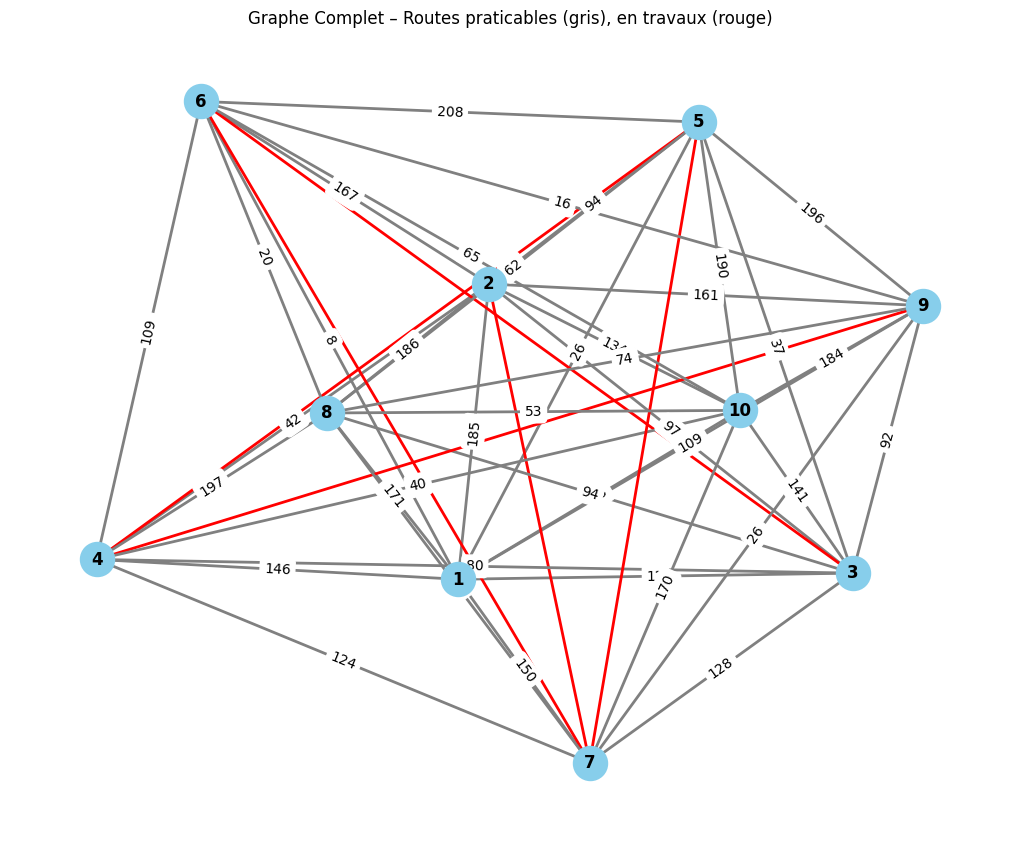

Matrice et ordre exportés avec succès vers « matrice_routes_ordre_generation_aleatoire.csv »


In [6]:
# Génère la matrice avec l'ordonnancement
matrice, ordre = generer_matrice_avec_ordre(n_sommets=10, cout_max=200, taux_travaux=0.2)

# Affichage de la matrice
afficher_matrice_liste(matrice)

# Visualisation du graphe
afficher_graphe(matrice)

# Exportation de la matrice
exporter_csv(matrice, ordre)


# Résolution exacte pour la comparaison avec les métaheuristiques

Dans cette étude, nous avons opté pour une **résolution exacte** du problème afin de disposer d'une **référence optimale**. Cette approche nous permet de comparer les résultats obtenus avec **les métaheuristiques** que nous allons utiliser pour résoudre des instances plus grandes et plus complexes.

### Objectifs de la résolution exacte :
- **Garantir l'optimalité des solutions** sur des petites instances du problème.
- **Comparer les résultats obtenus avec les métaheuristiques**, qui sont plus adaptées aux grandes instances, et déterminer celle qui offre la solution la plus optimisée en termes de temps et de qualité.

Nous avons choisi d'utiliser une méthode de **programmation linéaire en nombres entiers (PLNE)**, ce qui nous permet d'obtenir une solution optimale sur des tailles réduites de problème, mais qui devient rapidement peu pratique pour des instances de plus grande taille.


## Implémentation de la résolution exacte

L'approche exacte repose sur la modélisation du problème avec :

- **Une fonction objectif** visant à minimiser le coût total du parcours,
- **Des contraintes de degré**, assurant qu'il y a une entrée et une sortie pour chaque sommet,
- **Des contraintes de sous-tours**, formulées selon la méthode de **Miller-Tucker-Zemlin (MTZ)**, qui permet d'éviter la formation de sous-tours dans la solution (c'est-à-dire des boucles de villes non visitées dans l'ordre correct),
- **Des contraintes spécifiques**, imposant de respecter les points de collecte définis dans le problème (par exemple, en s'assurant que le départ se fasse vers un point de collecte et le retour provienne d'une ville qui n'est pas un point de collecte).

### Méthode exacte : Branch and Bound

Pour résoudre ce problème, nous avons utilisé une approche de **programmation linéaire en nombres entiers (PLNE)**, qui est basée sur un algorithme de **Branch and Bound** (B&B). L'algorithme de **Branch and Bound** est un mécanisme efficace pour résoudre des problèmes de PLNE, notamment les problèmes de TSP. Voici comment il fonctionne dans ce contexte :

- **Branching** : L'espace de recherche est divisé en sous-espaces plus petits (ou "branches"). Cela permet de se concentrer sur des parties spécifiques du problème, réduisant ainsi l'espace de recherche global.
- **Bounding** : À chaque étape, un calcul des bornes est effectué pour déterminer si un sous-espace peut contenir une solution optimale. Si ce n'est pas le cas, il est abandonné (c'est ce qu'on appelle le "cut").
- **Cutting planes** : En plus du Branch and Bound classique, l'algorithme utilisé dans notre cas (le solveur CBC) applique des "cutting planes", une méthode supplémentaire pour améliorer l'efficacité du processus de résolution.

### Outils utilisés

- **Python** et la bibliothèque **PuLP** ont été utilisées pour formuler et résoudre le problème de PLNE. PuLP permet de créer facilement des modèles de programmation linéaire et offre une interface pour interagir avec des solveurs comme CBC.
- **Le solveur CBC** est un solveur basé sur la méthode **Branch and Bound** et les "cutting planes", qui est particulièrement adapté pour les problèmes de grande taille comme celui du TSP. Nous avons défini une **limite de temps de 5 minutes par instance** pour éviter que le temps de calcul ne devienne trop long, surtout pour les grandes instances où la méthode exacte peut devenir impraticable.

In [ ]:
import pandas as pd
import pulp
import time

# === Chargement des données ===
# Lecture du fichier CSV contenant la matrice de coûts et la liste des points de collecte
df = pd.read_csv(r"data\matrice_routes_ordre_generation_aleatoire.csv", header=None)

# Récupération de la dernière ligne contenant les points de collecte
collect_line = df.iloc[-1, 0]
points_collecte = list(map(int, collect_line.split(';')))
points_collecte = [p - 1 for p in points_collecte]  # Conversion de l'indexation base 1 à base 0
non_collecte = [i for i in range(len(df) - 1) if i not in points_collecte]

# Nettoyage de la matrice pour ne garder que les coûts
df = df.iloc[:-1]
adj_matrix = df[0].str.split(';').apply(lambda x: list(map(int, x)))
cost_matrix = pd.DataFrame(adj_matrix.tolist())

# Remplacement des valeurs interdites (-1) par une grande constante (inaccessible)
INF = 10**6
cost_matrix = cost_matrix.replace(-1, INF)
n = cost_matrix.shape[0]

# === Construction du modèle PLNE ===
# Définition du problème d'optimisation
prob = pulp.LpProblem("TSP_with_Collecte_Constraints", pulp.LpMinimize)

# Variables binaires x[i,j] = 1 si on va de i vers j, 0 sinon
x = pulp.LpVariable.dicts("x",
    ((i, j) for i in range(n) for j in range(n)
     if i != j and cost_matrix.iloc[i, j] < INF), cat='Binary')

# Variables auxiliaires pour éliminer les sous-tours (formulation MTZ)
u = pulp.LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

# Fonction objectif : minimiser la somme des coûts de la tournée
prob += pulp.lpSum(cost_matrix.iloc[i, j] * x[i, j] for (i, j) in x)

# Contraintes de visite : chaque sommet doit être quitté et atteint exactement une fois
for i in range(n):
    prob += pulp.lpSum(x[i, j] for j in range(n) if (i, j) in x) == 1
    prob += pulp.lpSum(x[j, i] for j in range(n) if (j, i) in x) == 1

# Contraintes MTZ pour empêcher les sous-tours
for i in range(1, n):
    for j in range(1, n):
        if i != j and (i, j) in x:
            prob += u[i] - u[j] + n * x[i, j] <= n - 1

# Contraintes spécifiques au problème :
# - le départ doit se faire vers un point de collecte
prob += pulp.lpSum(x[0, j] for j in points_collecte if (0, j) in x) == 1

# - le retour doit venir d'une ville qui n'est pas un point de collecte
prob += pulp.lpSum(x[i, 0] for i in non_collecte if (i, 0) in x) == 1

# === Résolution du problème avec un time limit de 300 secondes ===
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=300)
start_time = time.time()
prob.solve(solver)
end_time = time.time()
elapsed = end_time - start_time

# === Reconstruction de la tournée à partir des variables optimales ===
tour_dict = {i: j for (i, j) in x if pulp.value(x[i, j]) > 0.5}
start = 0
tour = [start]
while True:
    next_city = tour_dict.get(tour[-1])
    if next_city is None or next_city == start:
        break
    tour.append(next_city)
tour.append(start)

# === Affichage des résultats ===
print("Statut :", pulp.LpStatus[prob.status])
print(f"Temps de résolution : {elapsed:.2f} secondes")
print("Points de collecte :", [p + 1 for p in points_collecte])
print("Coût total :", pulp.value(prob.objective))
print("Tournée (ordre réel) :")
for i in range(len(tour) - 1):
    print(f"{tour[i]+1} → {tour[i+1]+1}")


Statut : Optimal
Temps de résolution : 0.20 secondes
Points de collecte : [5, 6]
Coût total : 372.0
Tournée (ordre réel) :
1 → 6
6 → 9
9 → 7
7 → 8
8 → 10
10 → 4
4 → 2
2 → 5
5 → 3
3 → 1


## Comparaison avec les Métaheuristiques

L'analyse des temps de calcul de la méthode exacte montre que :

- Pour des **instances petites (n ≤ 30)**, la solution exacte est accessible rapidement. En effet, la méthode exacte, comme le **Branch and Bound** ou la **PLNE**, est capable de résoudre efficacement ces problèmes, car le nombre de variables et de contraintes est limité, et la recherche dans l'espace des solutions est relativement rapide.
  
- Pour des **instances plus grandes (n > 50)**, la méthode exacte devient **impraticable** en raison de la **croissance exponentielle du temps de calcul** **O(n!)**. Cette croissance est causée par la nécessité d'explorer une grande partie de l'espace de recherche des solutions entières, ce qui peut entraîner un **temps de calcul prohibitif**, même avec des algorithmes d'optimisation avancés comme le *branch-and-cut* ou le *cutting planes*.

Cela met en évidence la nécessité d'utiliser des **métaheuristiques**, qui permettent de contourner cette limitation tout en maintenant un compromis entre **temps de calcul** et **qualité des solutions**

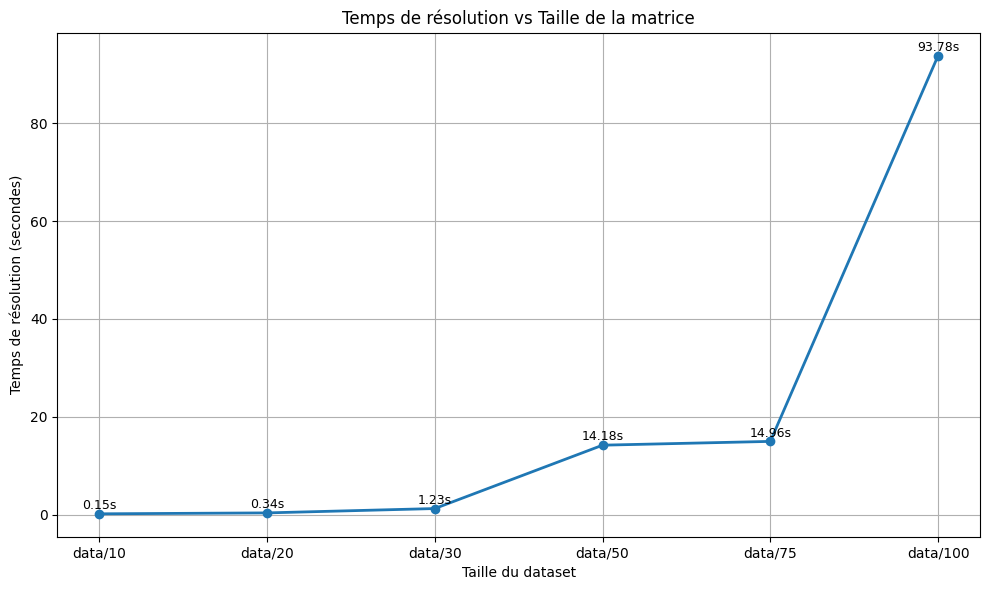

In [ ]:
import pandas as pd
import pulp
import time
import matplotlib.pyplot as plt

file_list = [
    r"data/matrice_routes_ordre_10.csv",
    r"data/matrice_routes_ordre_20.csv",
    r"data/matrice_routes_ordre_30.csv",
    #r"data/matrice_routes_ordre_40_Difficile.csv", 
    # Cette instance est particulièrement difficile à résoudre et prend beaucoup de temps pour être traitée.
    # Nous avons choisi de commenter cette ligne pour éviter des temps de calcul trop longs lors de l'exécution du script. 
    # Cependant, elle peut être décommentée et utilisée si nous disposons de plus de temps pour la résolution. 
    # Cette instance peut permettre de tester la robustesse de l'algorithme, mais nécessite un temps d'exécution prolongé, particulièrement pour les méthodes exactes.
    r"data/matrice_routes_ordre_50.csv",
    r"data/matrice_routes_ordre_75.csv",
    r"data/matrice_routes_ordre_100.csv"
]

results = []

for file in file_list:
    df = pd.read_csv(file, header=None)

    # Points de collecte
    collect_line = df.iloc[-1, 0]
    points_collecte = list(map(int, collect_line.split(';')))
    points_collecte = [p - 1 for p in points_collecte]
    non_collecte = [i for i in range(len(df) - 1) if i not in points_collecte]

    # Nettoyage de la matrice
    df = df.iloc[:-1]
    adj_matrix = df[0].str.split(';').apply(lambda x: list(map(int, x)))
    cost_matrix = pd.DataFrame(adj_matrix.tolist())
    INF = 10**6
    cost_matrix = cost_matrix.replace(-1, INF)
    n = cost_matrix.shape[0]

    # Modèle MILP
    prob = pulp.LpProblem("TSP", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(n)
                                    if i != j and cost_matrix.iloc[i, j] < INF), cat='Binary')
    u = pulp.LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

    prob += pulp.lpSum(cost_matrix.iloc[i, j] * x[i, j] for (i, j) in x)

    for i in range(n):
        prob += pulp.lpSum(x[i, j] for j in range(n) if (i, j) in x) == 1
        prob += pulp.lpSum(x[j, i] for j in range(n) if (j, i) in x) == 1

    for i in range(1, n):
        for j in range(1, n):
            if i != j and (i, j) in x:
                prob += u[i] - u[j] + n * x[i, j] <= n - 1

    # Contraintes spécifiques
    prob += pulp.lpSum(x[0, j] for j in points_collecte if (0, j) in x) == 1
    prob += pulp.lpSum(x[i, 0] for i in non_collecte if (i, 0) in x) == 1

    # Chrono
    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=300)
    start = time.time()
    prob.solve(solver)
    end = time.time()

    results.append({
        "taille": n,
        "temps": end - start,
        "nom": file.replace("matrice_routes_ordre_", "").replace(".csv", "")
    })

# === Affichage ===
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(df_results["nom"], df_results["temps"], marker='o', linewidth=2)
for i, row in df_results.iterrows():
    plt.text(row["nom"], row["temps"] + 1, f'{row["temps"]:.2f}s', ha='center', fontsize=9)
plt.xlabel("Taille du dataset")
plt.ylabel("Temps de résolution (secondes)")
plt.title("Temps de résolution vs Taille de la matrice")
plt.grid(True)
plt.tight_layout()
plt.show()



## Implémentation des méta-heuristiques

Dans le cadre de la résolution du problème du voyageur de commerce (TSP) avec contraintes de collecte, nous avons choisi d'utiliser plusieurs **méta-heuristiques** pour trouver des solutions optimales ou proches de l'optimal. Ces méthodes permettent d'explorer efficacement l'espace de solutions et d'obtenir des résultats de haute qualité, même pour des instances complexes du problème.

### Ant Colony Optimization (ACO)

L'**Ant Colony Optimization** (ACO) est inspirée du comportement des fourmis dans la nature. Les fourmis utilisent des phéromones pour guider leur recherche vers les solutions optimales. Dans le cadre du TSP, une population de fourmis explore l'espace de solutions en déposant des phéromones sur les arêtes de leur parcours. Ces traces influencent les fourmis suivantes, favorisant ainsi l'exploration des chemins les plus prometteurs. L'ACO est particulièrement efficace pour éviter les minima locaux et permet une exploration exhaustive de l'espace de recherche, offrant ainsi une bonne qualité de solution.

### Algorithmes génétiques

Les **algorithmes génétiques** (AG) sont inspirés du processus de sélection naturelle. Ils fonctionnent sur une population de solutions, combinant les meilleures solutions à travers des opérations de croisement et de mutation pour générer de nouvelles solutions. Ce processus évolutif permet à l'algorithme de converger vers des solutions de plus en plus optimales au fil des générations. Les algorithmes génétiques sont particulièrement adaptés aux problèmes complexes comme le TSP, où l'espace de recherche est vaste et nécessite une exploration diversifiée pour éviter de se retrouver dans des minima locaux.

### Recuit simulé (Simulated Annealing)

Le **recuit simulé** est une technique d'optimisation inspirée du processus physique de refroidissement des matériaux. L'algorithme commence par accepter des solutions de mauvaise qualité (celles qui augmentent le coût) avec une probabilité élevée. Au fur et à mesure que l'algorithme progresse, cette probabilité diminue, permettant à l'algorithme de se concentrer sur des solutions de meilleure qualité. Le recuit simulé est particulièrement utile pour les problèmes d'optimisation combinatoire comme le TSP, car il permet d'éviter les minima locaux et d'explorer plus largement l'espace de solutions.

# Algorithme de Colonie de Fourmis (ACO)

## Principe Général

L’algorithme ACO (**Ant Colony Optimization**) s’inspire du comportement des fourmis cherchant un chemin optimal entre leur nid et une source de nourriture. Chaque fourmi explore l’espace des solutions, et les bonnes solutions renforcent leur attractivité en déposant des **phéromones**.

Plus une route est empruntée, plus elle devient attractive pour les autres fourmis. Ce mécanisme collectif permet d’**approcher une solution optimale**.


##  Termes Clés

- **Fourmi** : une solution candidate construite à chaque itération  
- **Évaporation** : les phéromones s’estompent avec le temps  
- **Dépôt de phéromone** : les meilleures solutions renforcent leur chemin  
- **Exploration** : les fourmis choisissent leur chemin selon la probabilité  
- **Fonction de coût** : somme des distances du chemin


In [2]:
import random
import numpy as np
from typing import List, Tuple
import time
import matplotlib.pyplot as plt

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        points_collecte = list(map(int, lines[-1].split(';')))
        matrix = [list(map(int, line.split(';'))) for line in lines[:-1]]
        
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}") 


##  Initialisation de l’Algorithme

La classe `ACO_TSP` contient l'ensemble de la logique de l'algorithme de colonie de fourmis. Lors de l'initialisation :

- On stocke la matrice des distances (adjacence).
- On initialise une matrice de **phéromones** avec de faibles valeurs.
- On pré-calcule les **voisins accessibles** pour chaque ville.
- On vérifie les entrées (ville de départ, points de collecte…).


In [3]:
class ACO_TSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []

        # Phéromones initialisées à faible valeur
        self.pheromone = np.ones((self.num_cities + 1, self.num_cities + 1)) * 0.1

        # Connexions valides depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }

        self._validate_inputs()

    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
        if len(set(path)) != self.num_cities:
            return False
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        collect_candidates = [c for c in self.collecte if c in unvisited and self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
        nearest_collect = min(collect_candidates, key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        while unvisited:
            last = path[-1]
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            if not candidates:
                return None
            next_city = min(candidates, key=lambda x: self.matrix[last-1][x-1])
            path.append(next_city)
            unvisited.remove(next_city)
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
        path.append(self.start_node)
        return path if self.is_valid_path(path) else None

    def construct_ant_solution(self, alpha: float = 1.0, beta: float = 2.0) -> List[int]:
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        collect_candidates = [c for c in self.collecte if c in unvisited and self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
        first_collect = self.choose_next_city(self.start_node, collect_candidates, alpha, beta)
        path.append(first_collect)
        unvisited.remove(first_collect)
        while unvisited:
            last = path[-1]
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            if not candidates:
                return None
            next_city = self.choose_next_city(last, candidates, alpha, beta)
            path.append(next_city)
            unvisited.remove(next_city)
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
        path.append(self.start_node)
        return path if self.is_valid_path(path) else None

    def choose_next_city(self, current_city: int, candidates: List[int], alpha: float, beta: float) -> int:
        probabilities = []
        total = 0.0
        for city in candidates:
            tau = self.pheromone[current_city][city] ** alpha
            eta = (1.0 / self.matrix[current_city-1][city-1]) ** beta if self.matrix[current_city-1][city-1] != 0 else 1.0
            p = tau * eta
            probabilities.append(p)
            total += p
        if total == 0:
            return random.choice(candidates)
        probabilities = [p / total for p in probabilities]
        return np.random.choice(candidates, p=probabilities)

    def update_pheromones(self, solutions: List[List[int]], evaporation_rate: float = 0.5, Q: float = 100.0):
        self.pheromone *= (1.0 - evaporation_rate)
        for solution in solutions:
            if not solution:
                continue
            cost = self.calculate_cost(solution)
            delta_pheromone = Q / cost
            for i in range(len(solution)-1):
                from_city = solution[i]
                to_city = solution[i+1]
                self.pheromone[from_city][to_city] += delta_pheromone
        self.pheromone = np.clip(self.pheromone, 0.1, 10.0)

    def solve(self, num_ants: int = 10, iterations: int = 100, 
              alpha: float = 1.0, beta: float = 2.0,
              evaporation_rate: float = 0.5, Q: float = 100.0):
        start_time = time.time()
        initial_solution = self._greedy_construction()
        if initial_solution:
            self.best_solution = initial_solution
            self.best_cost = self.calculate_cost(initial_solution)
        else:
            while True:
                solution = self.construct_ant_solution(alpha, beta)
                if solution:
                    self.best_solution = solution
                    self.best_cost = self.calculate_cost(solution)
                    break
        self.cost_history.append(self.best_cost)
        for it in range(iterations):
            solutions = [self.construct_ant_solution(alpha, beta) for _ in range(num_ants)]
            solutions = [s for s in solutions if s]
            self.update_pheromones(solutions, evaporation_rate, Q)
            if solutions:
                current_best = min(solutions, key=lambda x: self.calculate_cost(x))
                current_cost = self.calculate_cost(current_best)
                if current_cost < self.best_cost:
                    self.best_solution = current_best
                    self.best_cost = current_cost
            self.cost_history.append(self.best_cost)
            if it % 10 == 0:
                avg = np.mean([self.calculate_cost(s) for s in solutions]) if solutions else float('inf')
                print(f"Iter {it}: Best={self.best_cost}, Avg={avg:.1f}")
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        return self.best_solution, self.best_cost


## Classe `ACO_TSP` : Algorithme de Colonie de Fourmis

La classe `ACO_TSP` implémente l'algorithme de Colonie de Fourmis (Ant Colony Optimization) pour résoudre un problème de tournée avec contraintes.

### Fonctionnalités principales :
- **Chargement de la matrice d'adjacence** (distances entre villes)
- **Initialisation des phéromones**
- **Construction de solutions** par des fourmis avec un mécanisme probabiliste basé sur :
  - Intensité des **phéromones** (`tau`)
  - **Distance** entre villes (`eta`)
- **Évaporation** et **renforcement** des phéromones après chaque génération
- **Mémorisation** de la meilleure solution trouvée

Chaque fourmi construit un chemin valide en respectant :
- Départ et arrivée sur la même ville
- Passage obligatoire par un point de collecte en 2ᵉ position
- Respect des connexions existantes




## Choix des paramètres pour l'heuristique de Colonies de Fourmis (ACO)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants sont choisis :

| Taille (nombre de villes) | Nombre de fourmis (`n_ants`) | Nombre d'itérations (`n_iterations`) | Importance phéromone (`alpha`) | Importance distance (`beta`) | Taux d'évaporation (`rho`) | Quantité de phéromone (`Q`) |
|:---|:---|:---|:---|:---|:---|:---|
| 10  | 10  | 50  | 1  | 2  | 0.5  | 100 |
| 20  | 20  | 100 | 1  | 3  | 0.5  | 100 |
| 30  | 30  | 150 | 1  | 4  | 0.4  | 100 |
| 40  | 40  | 200 | 1  | 5  | 0.4  | 100 |
| 50  | 50  | 250 | 1  | 5  | 0.3  | 100 |
| 75  | 75  | 400 | 1  | 5  | 0.3  | 100 |
| 100 | 100 | 500 | 1  | 5  | 0.2  | 100 |

### Explication des choix

- **Nombre de fourmis (`n_ants`)** : Le nombre de fourmis est proportionnel au nombre de villes. Plus il y a de villes, plus il est nécessaire d'avoir un nombre plus élevé de fourmis pour explorer efficacement l'espace de recherche. Une population de fourmis plus grande augmente la diversité des solutions explorées, ce qui permet d'éviter les solutions sous-optimales.

- **Nombre d'itérations (`n_iterations`)** : Le nombre d'itérations augmente avec la taille du problème. En effet, plus l'instance du problème est grande, plus il faut de temps pour que les fourmis trouvent des solutions de qualité. Augmenter le nombre d'itérations permet de donner à l'algorithme plus de temps pour converger vers une solution optimale.

- **Importance de la phéromone (`alpha`)** : L'importance de la phéromone est fixée à 1 pour un poids équilibré entre l'exploration et l'exploitation. Un alpha trop élevé pourrait rendre l'algorithme trop dépendant des anciennes solutions, limitant l'exploration de nouveaux chemins. Un alpha trop faible pourrait rendre l'algorithme trop exploratoire sans exploiter suffisamment les bonnes solutions trouvées.

- **Importance de la distance (`beta`)** : Le paramètre `beta` est augmenté avec la taille du problème pour accorder plus de poids aux chemins courts. Dans un problème avec un grand nombre de villes, l'algorithme doit être capable de privilégier les solutions offrant les distances les plus courtes, afin de mieux gérer la complexité accrue de l'espace de recherche.

- **Taux d'évaporation (`rho`)** : Le taux d'évaporation détermine la vitesse à laquelle la phéromone disparaît. Un taux d'évaporation plus faible (comme pour les grandes instances) permet de conserver plus longtemps les informations sur les bons chemins trouvés, ce qui favorise la convergence vers une solution optimale. Pour des instances plus petites, un taux d'évaporation plus élevé est suffisant.

- **Quantité de phéromone déposée (`Q`)** : Ce paramètre est constant dans toutes les instances, car il standardise l'apport de phéromone par les fourmis. Cela permet de maintenir un équilibre dans la mise à jour de la phéromone, indépendamment de la taille de l'instance.

## Exécution de l’Algorithme ACO

Dans cette étape, nous chargeons la matrice d’adjacence et les points de collecte depuis un fichier CSV, puis nous exécutons l'algorithme d'optimisation ACO. Nous appliquons des paramètres variables en fonction de la taille du problème, afin d'adapter l'algorithme aux différentes instances du problème.

### Paramètres utilisés :
- **num_ants** : nombre de fourmis à chaque itération. Ce paramètre sera ajusté en fonction du nombre de villes. Par exemple, pour 10 villes, nous utiliserons 10 fourmis, et pour 100 villes, nous utiliserons 100 fourmis. Cela permet de maintenir un équilibre entre exploration et exploitation des solutions.
  
- **iterations** : nombre total d’itérations. Nous allons augmenter le nombre d’itérations en fonction de la taille du problème. Pour des problèmes plus grands, un nombre plus élevé d’itérations est nécessaire pour permettre une meilleure convergence de l'algorithme.
  
- **alpha** : influence des phéromones. Ce paramètre sera ajusté pour donner un poids suffisant aux informations collectées par les fourmis tout en évitant de rendre l'algorithme trop dépendant des solutions précédentes. À mesure que la taille du problème augmente, il peut être nécessaire d’augmenter légèrement ce paramètre pour favoriser l’exploitation des bons chemins.
  
- **beta** : influence de la distance (heuristique). À mesure que le nombre de villes augmente, nous avons tendance à augmenter l'importance de la distance pour encourager les fourmis à privilégier des solutions plus courtes. Ce paramètre ajusté en fonction de la taille du problème peut aider à mieux explorer l'espace de recherche.
  
- **evaporation_rate** : taux d’évaporation des phéromones. Le taux d'évaporation sera ajusté pour les problèmes plus grands, afin de garder plus longtemps les bonnes solutions trouvées, tout en permettant à l'algorithme de ne pas être "bloqué" par de mauvaises solutions persistantes. Des valeurs plus faibles seront utilisées pour les instances de grande taille.

- **Q** : intensité du dépôt de phéromone. Ce paramètre reste constant tout au long des différentes tailles de problèmes pour standardiser l’apport de phéromone dans l'algorithme.

### Adaptation des paramètres en fonction du nombre de villes
Afin d’optimiser l'algorithme pour différentes tailles de problèmes, les paramètres seront ajustés en fonction du nombre de villes présentes dans l’instance <u>**à la fin du NoteBook**</u>. Plus spécifiquement :
- Le nombre de fourmis (`num_ants`) et le nombre d’itérations seront proportionnels à la taille du problème. Cela garantit une meilleure exploration de l’espace de recherche pour les grandes instances.
- Les paramètres de phéromones (`alpha`, `beta`) seront augmentés ou diminués pour ajuster l'équilibre entre exploration (nouvelles solutions) et exploitation (solutions existantes).
- Le taux d'évaporation sera ajusté pour garantir une bonne gestion de la mémoire des solutions.

Ces choix permettront de tester et comparer les performances de l’algorithme ACO selon différentes tailles d’instances et de tirer des conclusions sur les meilleurs paramètres pour chaque cas spécifique.


Chargement du fichier data/matrice_routes_ordre_10.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [3, 7]
- Taille de la matrice: (10, 10)
Iter 0: Best=465, Avg=611.1
Iter 10: Best=465, Avg=520.3
Iter 20: Best=465, Avg=521.3
Iter 30: Best=465, Avg=522.1
Iter 40: Best=465, Avg=516.0
Iter 50: Best=465, Avg=516.0
Iter 60: Best=465, Avg=516.0
Iter 70: Best=465, Avg=516.9
Iter 80: Best=465, Avg=522.7
Iter 90: Best=465, Avg=520.7

Optimisation terminée en 1.47s
Meilleur coût trouvé: 465
Solution valide: True


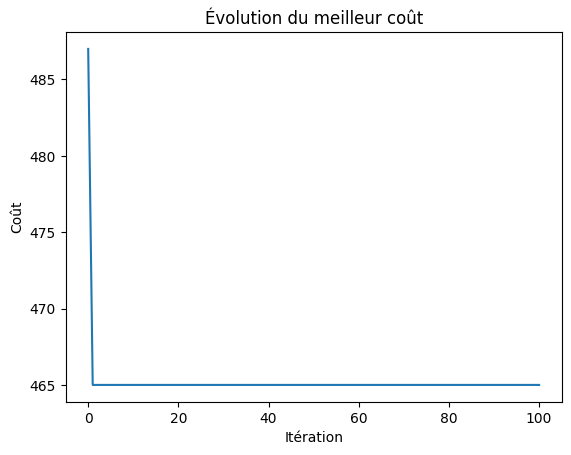


Meilleur chemin trouvé :
Départ: [1, 3, 6]...[2, 8, 1]
Longueur du chemin: 11 villes
Coût total: 465
Chargement du fichier data/matrice_routes_ordre_20.csv...

Paramètres du problème:
- Nombre de villes: 20
- Points de collecte: [5, 13]
- Taille de la matrice: (20, 20)
Iter 0: Best=862, Avg=1112.7
Iter 10: Best=808, Avg=981.3
Iter 20: Best=808, Avg=940.7
Iter 30: Best=808, Avg=916.6
Iter 40: Best=808, Avg=912.4
Iter 50: Best=808, Avg=931.9
Iter 60: Best=808, Avg=912.9
Iter 70: Best=808, Avg=908.8
Iter 80: Best=808, Avg=924.7
Iter 90: Best=808, Avg=920.2

Optimisation terminée en 3.74s
Meilleur coût trouvé: 808
Solution valide: True


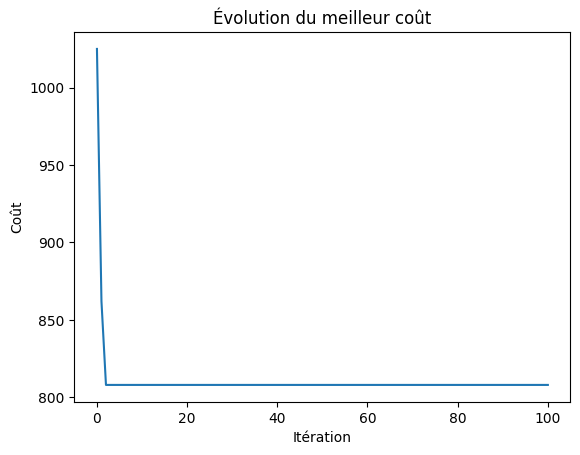


Meilleur chemin trouvé :
Départ: [1, 13, 5]...[3, 16, 1]
Longueur du chemin: 21 villes
Coût total: 808
Chargement du fichier data/matrice_routes_ordre_30.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [5, 14]
- Taille de la matrice: (30, 30)
Iter 0: Best=837, Avg=1160.0
Iter 10: Best=776, Avg=1035.1
Iter 20: Best=776, Avg=1047.4
Iter 30: Best=775, Avg=1050.2
Iter 40: Best=775, Avg=1052.0
Iter 50: Best=775, Avg=1053.9
Iter 60: Best=775, Avg=1060.6
Iter 70: Best=775, Avg=1066.7
Iter 80: Best=775, Avg=1051.6
Iter 90: Best=775, Avg=1053.3

Optimisation terminée en 7.43s
Meilleur coût trouvé: 775
Solution valide: True


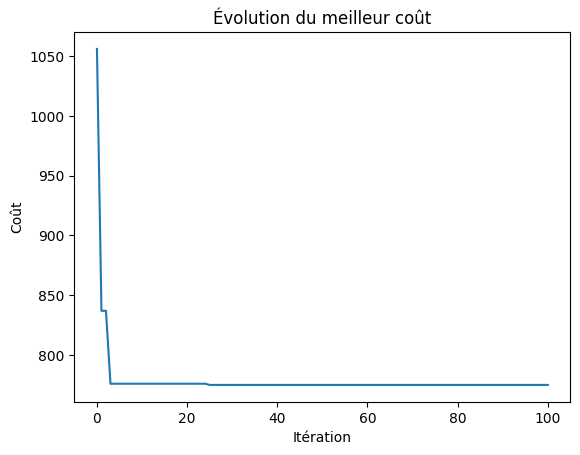


Meilleur chemin trouvé :
Départ: [1, 5, 23]...[19, 26, 1]
Longueur du chemin: 31 villes
Coût total: 775
Chargement du fichier data/matrice_routes_ordre_50.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [34, 9]
- Taille de la matrice: (50, 50)
Iter 0: Best=910, Avg=1097.3
Iter 10: Best=674, Avg=900.4
Iter 20: Best=673, Avg=803.0
Iter 30: Best=673, Avg=790.0
Iter 40: Best=673, Avg=830.0
Iter 50: Best=668, Avg=800.2
Iter 60: Best=668, Avg=792.9
Iter 70: Best=668, Avg=754.7
Iter 80: Best=668, Avg=786.4
Iter 90: Best=668, Avg=773.8

Optimisation terminée en 17.90s
Meilleur coût trouvé: 668
Solution valide: True


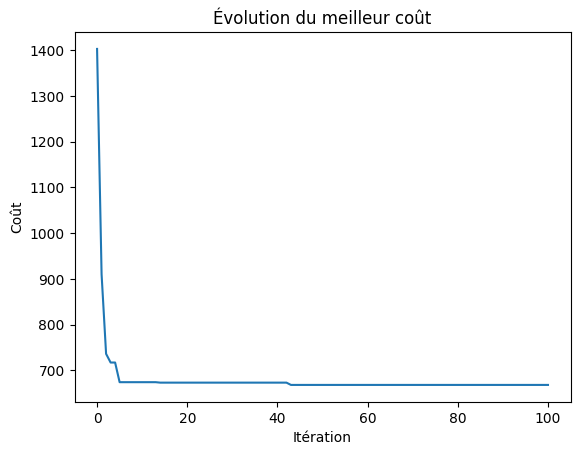


Meilleur chemin trouvé :
Départ: [1, 34, 29]...[8, 49, 1]
Longueur du chemin: 51 villes
Coût total: 668
Chargement du fichier data/matrice_routes_ordre_75.csv...

Paramètres du problème:
- Nombre de villes: 75
- Points de collecte: [25, 37]
- Taille de la matrice: (75, 75)
Iter 0: Best=978, Avg=1351.4
Iter 10: Best=837, Avg=1168.8
Iter 20: Best=837, Avg=1153.7
Iter 30: Best=837, Avg=1089.3
Iter 40: Best=808, Avg=1087.8
Iter 50: Best=808, Avg=1147.4
Iter 60: Best=808, Avg=1075.5
Iter 70: Best=808, Avg=1077.7
Iter 80: Best=808, Avg=1082.5
Iter 90: Best=808, Avg=1091.0

Optimisation terminée en 36.85s
Meilleur coût trouvé: 808
Solution valide: True


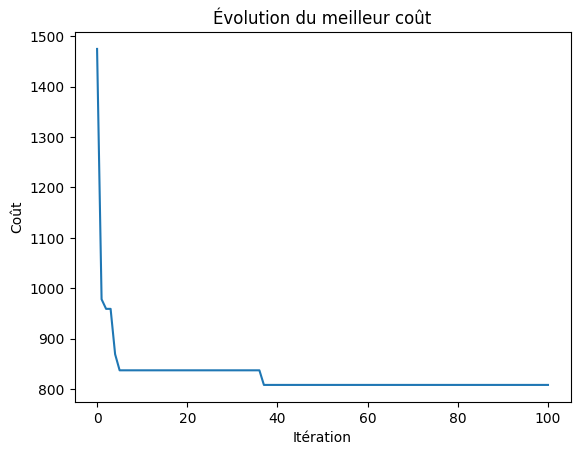


Meilleur chemin trouvé :
Départ: [1, 25, 28]...[40, 30, 1]
Longueur du chemin: 76 villes
Coût total: 808
Chargement du fichier data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Iter 0: Best=1105, Avg=1358.2
Iter 10: Best=737, Avg=1113.0
Iter 20: Best=731, Avg=1116.8
Iter 30: Best=731, Avg=1138.7
Iter 40: Best=731, Avg=1086.9
Iter 50: Best=731, Avg=1070.8
Iter 60: Best=731, Avg=1092.4
Iter 70: Best=731, Avg=1042.4
Iter 80: Best=731, Avg=1050.8
Iter 90: Best=718, Avg=1072.1

Optimisation terminée en 62.70s
Meilleur coût trouvé: 718
Solution valide: True


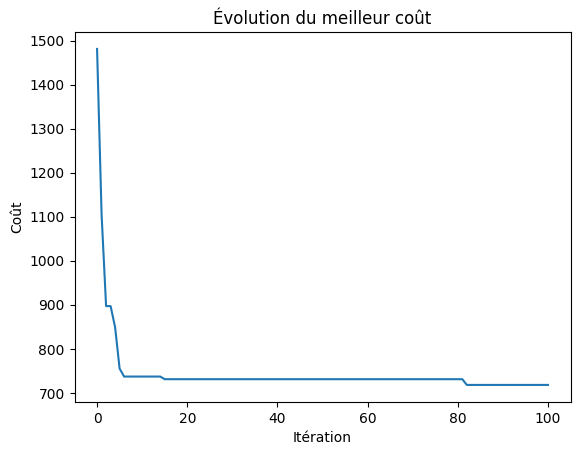


Meilleur chemin trouvé :
Départ: [1, 46, 95]...[17, 64, 1]
Longueur du chemin: 101 villes
Coût total: 718
Chargement du fichier data/matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [5, 6]
- Taille de la matrice: (10, 10)
Iter 0: Best=372, Avg=527.4
Iter 10: Best=372, Avg=446.2
Iter 20: Best=372, Avg=472.9
Iter 30: Best=372, Avg=446.5
Iter 40: Best=372, Avg=439.9
Iter 50: Best=372, Avg=416.6
Iter 60: Best=372, Avg=419.5
Iter 70: Best=372, Avg=412.0
Iter 80: Best=372, Avg=423.8
Iter 90: Best=372, Avg=447.4

Optimisation terminée en 1.44s
Meilleur coût trouvé: 372
Solution valide: True


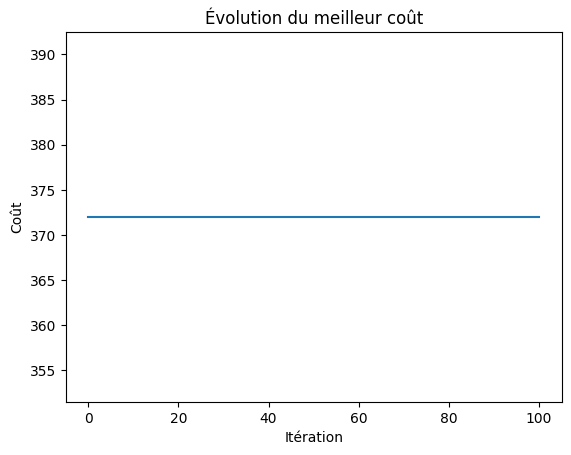


Meilleur chemin trouvé :
Départ: [1, 6, 9]...[5, 3, 1]
Longueur du chemin: 11 villes
Coût total: 372


In [5]:
if __name__ == "__main__":
    try:
        liste = ["data/matrice_routes_ordre_10.csv",
                 "data/matrice_routes_ordre_20.csv",
                 "data/matrice_routes_ordre_30.csv",
                 #r"data/matrice_routes_ordre_40_Difficile.csv", 
                    # Cette instance est particulièrement difficile à résoudre et prend beaucoup de temps pour être traitée.
                    # Nous avons choisi de commenter cette ligne pour éviter des temps de calcul trop longs lors de l'exécution du script. 
                    # Cependant, elle peut être décommentée et utilisée si nous disposons de plus de temps pour la résolution. 
                    # Cette instance peut permettre de tester la robustesse de l'algorithme, mais nécessite un temps d'exécution prolongé, particulièrement pour les méthodes exactes.
                 "data/matrice_routes_ordre_50.csv",
                 "data/matrice_routes_ordre_75.csv",
                 "data/matrice_routes_ordre_100.csv",
                 "data/matrice_routes_ordre_generation_aleatoire.csv"
                 ]
        for i in range(len(liste)):
            file_path = liste[i]  # Remplace ce chemin si nécessaire
            print(f"Chargement du fichier {file_path}...")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            
            print("\nParamètres du problème:")
            print(f"- Nombre de villes: {len(matrix)}")
            print(f"- Points de collecte: {collecte}")
            print(f"- Taille de la matrice: {matrix.shape}")
            
            # Instanciation et résolution
            solver = ACO_TSP(matrix, collecte)
            solution, cost = solver.solve(
                num_ants=50,
                iterations=100,
                alpha=1.0,
                beta=3.0,
                evaporation_rate=0.4,
                Q=100.0
            )
            
            print("\nMeilleur chemin trouvé :")
            solution_int = [int(city) for city in solution]
            print(f"Départ: {solution_int[:3]}...{solution_int[-3:]}")
            print(f"Longueur du chemin: {len(solution)} villes")
            print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f" Erreur: {str(e)}") 


# Algorithme Génétique

## Principe Général

Un **algorithme génétique** est une méthode d’optimisation inspirée du processus de l’évolution naturelle. Il repose sur trois grands principes : **variation**, **adaptation** et **hérédité**.

Chaque **individu** représente une solution possible au problème (par exemple, un trajet dans le cas du problème du voyageur de commerce), codé sous forme de **chromosome** (liste de villes).


## Termes Clés

- **Individu** : un trajet possible  
- **Population** : un ensemble de trajets  
- **Mutation** : modification aléatoire d’un trajet  
- **Adaptation** : plus le trajet est court, plus il est adapté  
- **Sélection naturelle** : les moins adaptés sont éliminés


## Fonctionnement Étape par Étape

### 1. Initialisation de la Population
Création aléatoire d’une population d’individus. Cette diversité initiale est essentielle pour explorer efficacement l’espace des solutions.

### 2. Évaluation de l’Aptitude (*Fitness*)
Chaque individu est évalué selon une **fonction d’aptitude**, qui mesure la qualité de la solution (ex: distance totale du trajet).

### 3. Sélection
Les meilleurs individus sont choisis pour se reproduire.  
Méthodes courantes : **roulette**, **tournoi**, etc.  
Objectif : favoriser les bons candidats, tout en conservant une certaine diversité.

### 4. Croisement (*Crossover*)
Des couples d’individus sélectionnés produisent des **descendants** en combinant leurs chromosomes. Cela permet de créer de nouvelles solutions à partir des meilleures existantes.

### 5. Mutation
Des modifications aléatoires sont appliquées pour introduire de la nouveauté et éviter la stagnation. Cela permet de maintenir la diversité génétique.

### 6. Remplacement
Les nouveaux individus remplacent partiellement ou totalement la population précédente selon une stratégie choisie (ex: **élitisme**).

### 7. Itération
Les étapes sont répétées jusqu’à atteindre un critère d’arrêt :  
nombre de générations, seuil de qualité atteint, etc.



In [6]:
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt

In [7]:
def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

## 1. Initialisation et Validation
 La classe GeneticTSP résout un problème de tournée avec contraintes spécifiques :
 - Doit commencer et finir à un point donné
 - Doit passer par certains points de collecte
 - Doit visiter toutes les villes exactement une fois

In [8]:
class GeneticTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_initial_population(self, size: int) -> List[List[int]]:
        """Génère une population initiale diversifiée."""
        population = []
        
        # 1. Solutions gloutonnes variées
        for _ in range(size//2):
            sol = self._greedy_construction()
            if sol:
                population.append(sol)
        
        # 2. Solutions semi-aléatoires avec contraintes respectées
        while len(population) < size:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                break
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                population.append(path)
        
        return population[:size]

    def tournament_selection(self, population: List[List[int]], tournament_size: int = 5) -> List[List[int]]:
        """Sélection par tournoi."""
        selected = []
        for _ in range(len(population)):
            participants = random.sample(population, min(tournament_size, len(population)))
            winner = min(participants, key=lambda x: self.calculate_cost(x))
            selected.append(winner)
        return selected

    def ordered_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Croisement ordonné pour préserver les permutations valides."""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size-1), 2))
        
        def create_child(p1, p2):
            child = [None]*size
            child[0] = child[-1] = self.start_node
            
            # Copier le segment entre start et end
            child[start:end] = p1[start:end]
            
            # Remplir avec les villes de p2 dans l'ordre
            remaining = [city for city in p2 if city not in child[start:end]]
            ptr = 1
            for i in range(1, size-1):
                if child[i] is None:
                    child[i] = remaining[ptr-1]
                    ptr += 1
            return child
        
        child1 = create_child(parent1, parent2)
        child2 = create_child(parent2, parent1)
        
        # Validation des enfants
        valid_child1 = child1 if self.is_valid_path(child1) else parent1
        valid_child2 = child2 if self.is_valid_path(child2) else parent2
        
        return valid_child1, valid_child2

    def mutate(self, path: List[int], mutation_rate: float = 0.1) -> List[int]:
        """Mutation par échange de deux villes."""
        if random.random() > mutation_rate or len(path) <= 3:
            return path
            
        # On ne mute pas le départ, l'arrivée ou les points de collecte contraints
        mutable_positions = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
        if len(path) > 4:
            mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
            
        if len(mutable_positions) < 2:
            return path
            
        i, j = random.sample(mutable_positions, 2)
        new_path = path.copy()
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        return new_path if self.is_valid_path(new_path) else path

    def solve(self, population_size: int = 100, generations: int = 200, 
             mutation_rate: float = 0.15, elite_size: int = 10):
        """Algorithme génétique principal."""
        start_time = time.time()
        
        # Initialisation
        population = self.generate_initial_population(population_size)
        if not population:
            raise ValueError("Impossible de générer une population initiale valide. " +
                           "Vérifiez les contraintes et la matrice d'adjacence.")
            
        population.sort(key=lambda x: self.calculate_cost(x))
        self.best_solution = population[0]
        self.best_cost = self.calculate_cost(population[0])
        self.cost_history.append(self.best_cost)
        
        # Évolution
        for gen in range(generations):
            # Sélection élitiste
            elites = population[:elite_size]
            
            # Sélection
            selected = self.tournament_selection(population)
            
            # Croisement
            offspring = []
            for i in range(0, len(selected)-1, 2):
                child1, child2 = self.ordered_crossover(selected[i], selected[i+1])
                offspring.append(child1)
                offspring.append(child2)
            
            # Mutation
            mutated = [self.mutate(child, mutation_rate) for child in offspring]
            
            # Nouvelle population
            population = elites + mutated
            population.sort(key=lambda x: self.calculate_cost(x))
            population = population[:population_size]
            
            # Mise à jour meilleure solution
            current_best = population[0]
            current_cost = self.calculate_cost(current_best)
            if current_cost < self.best_cost:
                self.best_solution = current_best
                self.best_cost = current_cost
            self.cost_history.append(self.best_cost)
            
            # Affichage progression
            if gen % 10 == 0:
                avg_cost = np.mean([self.calculate_cost(p) for p in population])
                print(f"Gen {gen}: Best={self.best_cost} Avg={avg_cost:.1f}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Génération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

## 2. Vérification et Calcul des Solutions
### Contrôle de validité d'un chemin
Un chemin valide doit :
1. Commencer et finir au point de départ
2. Passer par un point de collecte en 2ème position
3. Visiter toutes les villes exactement une fois
4. Ne contenir que des connexions valides (pas de -1 dans la matrice)

In [9]:
    def is_valid_path(self, path: List[int]) -> bool:
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        if len(set(path)) != self.num_cities:
            return False
            
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

## 3. Construction des Solutions Initiales
Stratégie hybride pour la population initiale :
- 50% de solutions gloutonnes (optimisées localement)
- 50% de solutions aléatoires (diversité)

## 4. Opérateurs Génétiques
### Sélection par Tournoi
- Sélectionne les meilleurs individus par compétition
- Maintient la pression de sélection

### Croisement Ordonné (OX)
- Préserve l'ordre des villes
- Garantit des solutions valides
- Combine des segments de parents

### Mutation Contrôlée
- Échange deux villes aléatoirement
- Préserve les contraintes de collecte
- Taux de mutation paramétrable

## 5. Algorithme Principal
### Processus Évolutif
1. Initialisation de la population
2. Sélection des parents
3. Croisement et mutation
4. Élitisme (conservation des meilleurs solutions)
5. Convergence vers une solution optimale

## Choix des paramètres pour l'heuristique d'Algorithme Génétique (GA)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants sont choisis :

| Taille (nombre de villes) | Taille de la population (`population_size`) | Nombre de générations (`n_generations`) | Taux de croisement (`crossover_rate`) | Taux de mutation (`mutation_rate`) | Sélection |
|:---|:---|:---|:---|:---|:---|
| 10 | 20 | 50 | 0.9 | 0.2 | Tournoi |
| 20 | 40 | 100 | 0.9 | 0.2 | Tournoi |
| 30 | 60 | 150 | 0.9 | 0.15 | Tournoi |
| 40 | 80 | 200 | 0.9 | 0.15 | Tournoi |
| 50 | 100 | 250 | 0.9 | 0.1 | Tournoi |
| 75 | 150 | 400 | 0.9 | 0.1 | Tournoi |
| 100 | 200 | 500 | 0.9 | 0.05 | Tournoi |

### Explication des choix

- **Taille de la population (`population_size`)** : 
  - La taille de la population est directement liée au nombre de villes. Plus le nombre de villes augmente, plus il est nécessaire d'avoir une population plus grande pour garantir une diversité génétique suffisante et éviter la convergence prématurée vers des solutions sous-optimales. Par exemple, pour 10 villes, une petite population de 20 individus suffit, mais pour 100 villes, il est nécessaire d'avoir 200 individus pour explorer efficacement l'espace des solutions.
  
- **Nombre de générations (`n_generations`)** : 
  - Le nombre de générations représente le nombre de fois que la population évoluera. Il augmente avec la taille du problème, car des instances plus grandes nécessitent plus d'itérations pour permettre à l'algorithme de converger vers une solution optimale. Pour 10 villes, 50 générations peuvent suffire, tandis que pour 100 villes, 500 générations sont nécessaires pour une recherche approfondie.

- **Taux de croisement (`crossover_rate`)** : 
  - Le taux de croisement détermine la probabilité d'échanger des informations entre deux parents pour créer de nouveaux individus (enfants). Un taux de 0.9 est choisi pour assurer un fort échange génétique entre les solutions tout en maintenant une diversité au sein de la population. Cela permet d'éviter la stagnation dans les solutions en introduisant constamment de nouvelles combinaisons de génomes.

- **Taux de mutation (`mutation_rate`)** : 
  - Le taux de mutation détermine la probabilité de modifier un individu aléatoirement pour introduire de nouvelles variations génétiques. Pour des instances de plus grande taille, le taux de mutation est légèrement diminué pour éviter de perturber trop fortement les bonnes solutions trouvées, ce qui pourrait conduire à la perte d'informations précieuses. Pour des petites instances, un taux plus élevé (0.2) est utilisé pour maintenir l'exploration de nouvelles solutions.

- **Méthode de sélection** :
  - La méthode de sélection choisie est le **Tournoi** (Tournament selection). Cette méthode est efficace pour choisir des solutions robustes tout en conservant une diversité génétique. Elle fonctionne en organisant un tournoi entre un sous-ensemble d'individus de la population et en sélectionnant le meilleur d'entre eux. Cela permet de maintenir une pression de sélection tout en évitant la perte de diversité.

### Recommandations supplémentaires

- **Élitisme** : Il est recommandé d'utiliser une stratégie d'élitisme où les meilleures solutions d'une génération sont conservées pour la génération suivante. Cela garantit que les meilleures solutions ne seront jamais perdues, assurant ainsi une progression constante vers une meilleure solution.
  
- **Mutation adaptative** : Le taux de mutation peut être ajusté dynamiquement au cours des générations. L'idée est de diminuer progressivement le taux de mutation à mesure que l'algorithme converge, afin de stabiliser la recherche et d'éviter de perturber les solutions optimales déjà trouvées.

- **Croisement spécifique TSP** : Pour le problème du voyageur de commerce (TSP), il est crucial d'utiliser des opérateurs de croisement adaptés, comme l'**Order Crossover (OX)** ou le **Partially Mapped Crossover (PMX)**, qui respectent les contraintes spécifiques du problème (comme ne pas répéter de villes dans une tournée).



### Paramètres utilisés :
- **population_size** : Taille de la population à chaque génération. Ce paramètre sera ajusté en fonction du nombre de villes. Par exemple, pour 10 villes, une population plus petite (20 individus) est suffisante, mais pour 100 villes, une population plus grande (200 individus) est nécessaire pour maintenir la diversité génétique et éviter la convergence prématurée. Plus la taille du problème augmente, plus la population doit être importante pour explorer efficacement l'espace des solutions.

- **generations** : Nombre total de générations. Le nombre de générations est directement lié à la taille du problème. Pour des problèmes plus grands, il est nécessaire d'avoir plus de générations pour permettre à l'algorithme de converger vers des solutions optimales. Par exemple, pour 10 villes, 50 générations suffisent, tandis que pour 100 villes, 500 générations peuvent être nécessaires pour explorer et affiner la solution.

- **mutation_rate** : Taux de mutation. Ce paramètre contrôle la probabilité de mutation d'un individu dans chaque génération. Le taux de mutation est ajusté en fonction de la taille du problème pour éviter de perturber trop fortement les bonnes solutions. Pour des instances plus petites, un taux de mutation plus élevé (0.2) est utilisé pour maintenir une exploration de nouvelles solutions, tandis que pour des instances plus grandes, un taux de mutation plus faible (0.05 - 0.1) est utilisé pour éviter de détruire des solutions prometteuses.

- **elite_size** : Taille de l'élite, c'est-à-dire le nombre d'individus les mieux classés d'une génération qui sont directement conservés pour la génération suivante. Ce paramètre garantit que les meilleures solutions ne sont jamais perdues, assurant ainsi une progression constante vers des solutions de plus en plus optimisées. Plus la taille du problème augmente, plus il est important de conserver un nombre significatif de solutions de qualité.

### Adaptation des paramètres en fonction du nombre de villes
Afin d’optimiser l'algorithme pour différentes tailles de problèmes, les paramètres seront ajustés en fonction du nombre de villes présentes dans l’instance <u>**à la fin du NoteBook**</u>. Plus spécifiquement :
- Le **population_size** et le **nombre de générations** seront augmentés proportionnellement à la taille du problème. Cela permettra à l'algorithme de mieux explorer l’espace de recherche pour des instances plus grandes et d’assurer une meilleure convergence vers une solution optimale.
- Le **taux de mutation** sera ajusté pour maintenir un équilibre entre exploration et exploitation des solutions. Un taux de mutation plus faible pour les grandes instances permet de préserver la stabilité des bonnes solutions déjà trouvées, tandis qu'un taux plus élevé pour les petites instances encourage l'exploration.
- Le **elite_size** sera ajusté pour garantir que les meilleures solutions de chaque génération soient transmises à la génération suivante, en fonction de la taille de l'instance.

Ces ajustements permettront de tester et de comparer les performances de l'algorithme génétique selon différentes tailles d'instances, et de tirer des conclusions sur les meilleurs paramètres pour chaque cas spécifique.


Chargement du fichier data/matrice_routes_ordre_10.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [3, 7]
- Taille de la matrice: (10, 10)
Gen 0: Best=527 Avg=718.6
Gen 10: Best=509 Avg=520.4
Gen 20: Best=509 Avg=521.5
Gen 30: Best=509 Avg=517.8
Gen 40: Best=509 Avg=514.4
Gen 50: Best=509 Avg=517.1
Gen 60: Best=509 Avg=512.7
Gen 70: Best=509 Avg=518.0
Gen 80: Best=509 Avg=510.4
Gen 90: Best=509 Avg=513.1
Gen 100: Best=509 Avg=515.1
Gen 110: Best=509 Avg=511.4
Gen 120: Best=509 Avg=513.2
Gen 130: Best=509 Avg=516.1
Gen 140: Best=509 Avg=516.5
Gen 150: Best=509 Avg=512.5
Gen 160: Best=509 Avg=516.9
Gen 170: Best=509 Avg=509.4
Gen 180: Best=509 Avg=518.1
Gen 190: Best=509 Avg=516.0

Optimisation terminée en 0.60s
Meilleur coût trouvé: 509
Solution valide: True


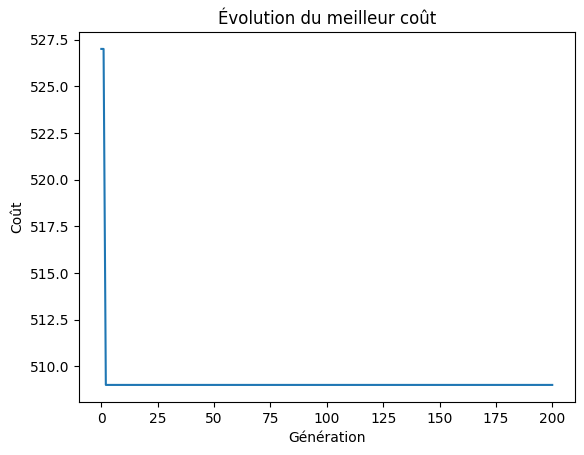


Meilleur chemin trouvé (extrait):
Départ: [1, 7, 10]...[2, 8, 1]
Longueur: 11 villes
Coût total: 509
Chargement du fichier data/matrice_routes_ordre_20.csv...

Paramètres du problème:
- Nombre de villes: 20
- Points de collecte: [5, 13]
- Taille de la matrice: (20, 20)
Gen 0: Best=1025 Avg=1025.0
Gen 10: Best=1016 Avg=1016.0
Gen 20: Best=1016 Avg=1016.0
Gen 30: Best=1016 Avg=1016.0
Gen 40: Best=1016 Avg=1016.0
Gen 50: Best=1016 Avg=1016.0
Gen 60: Best=1016 Avg=1016.0
Gen 70: Best=1016 Avg=1016.0
Gen 80: Best=1016 Avg=1016.0
Gen 90: Best=1016 Avg=1016.0
Gen 100: Best=1016 Avg=1016.0
Gen 110: Best=1016 Avg=1016.0
Gen 120: Best=1016 Avg=1016.0
Gen 130: Best=1016 Avg=1016.0
Gen 140: Best=1016 Avg=1016.0
Gen 150: Best=1016 Avg=1017.0
Gen 160: Best=1016 Avg=1016.0
Gen 170: Best=1016 Avg=1016.0
Gen 180: Best=1016 Avg=1016.0
Gen 190: Best=1016 Avg=1016.0

Optimisation terminée en 1.00s
Meilleur coût trouvé: 1016
Solution valide: True


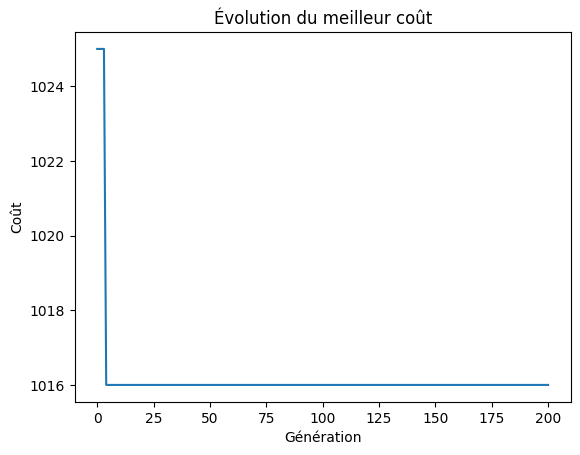


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 5]...[10, 7, 1]
Longueur: 21 villes
Coût total: 1016
Chargement du fichier data/matrice_routes_ordre_30.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [5, 14]
- Taille de la matrice: (30, 30)
Gen 0: Best=1056 Avg=1056.0
Gen 10: Best=1056 Avg=1063.8
Gen 20: Best=1056 Avg=1060.3
Gen 30: Best=1008 Avg=1027.2
Gen 40: Best=1008 Avg=1008.0
Gen 50: Best=1008 Avg=1008.0
Gen 60: Best=1008 Avg=1008.0
Gen 70: Best=1008 Avg=1011.4
Gen 80: Best=1008 Avg=1009.1
Gen 90: Best=1008 Avg=1009.3
Gen 100: Best=1008 Avg=1008.7
Gen 110: Best=1008 Avg=1008.0
Gen 120: Best=1008 Avg=1009.1
Gen 130: Best=1008 Avg=1011.0
Gen 140: Best=1008 Avg=1008.0
Gen 150: Best=1008 Avg=1008.0
Gen 160: Best=1008 Avg=1008.0
Gen 170: Best=1008 Avg=1009.2
Gen 180: Best=1008 Avg=1008.0
Gen 190: Best=1008 Avg=1010.3

Optimisation terminée en 1.42s
Meilleur coût trouvé: 1008
Solution valide: True


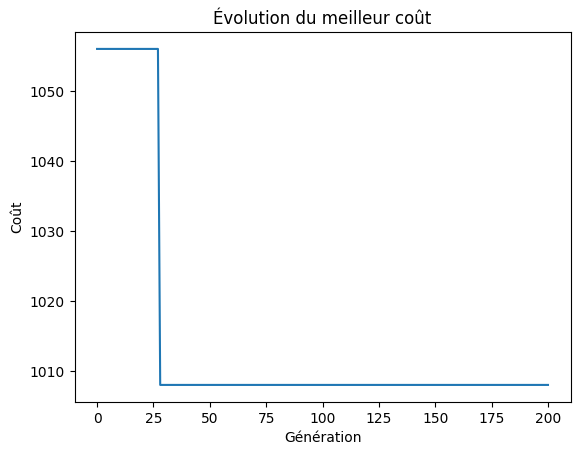


Meilleur chemin trouvé (extrait):
Départ: [1, 5, 9]...[7, 12, 1]
Longueur: 31 villes
Coût total: 1008
Chargement du fichier data/matrice_routes_ordre_50.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [34, 9]
- Taille de la matrice: (50, 50)
Gen 0: Best=4240 Avg=4616.6
Gen 10: Best=3589 Avg=3758.2
Gen 20: Best=3212 Avg=3225.1
Gen 30: Best=2799 Avg=2886.1
Gen 40: Best=2572 Avg=2572.0
Gen 50: Best=2450 Avg=2470.3
Gen 60: Best=2232 Avg=2315.8
Gen 70: Best=2228 Avg=2229.2
Gen 80: Best=2086 Avg=2086.3
Gen 90: Best=2037 Avg=2037.0
Gen 100: Best=2007 Avg=2028.8
Gen 110: Best=1977 Avg=1977.0
Gen 120: Best=1875 Avg=1875.0
Gen 130: Best=1816 Avg=1816.0
Gen 140: Best=1739 Avg=1740.5
Gen 150: Best=1629 Avg=1629.0
Gen 160: Best=1629 Avg=1629.0
Gen 170: Best=1629 Avg=1630.5
Gen 180: Best=1566 Avg=1566.0
Gen 190: Best=1490 Avg=1493.7

Optimisation terminée en 2.29s
Meilleur coût trouvé: 1490
Solution valide: True


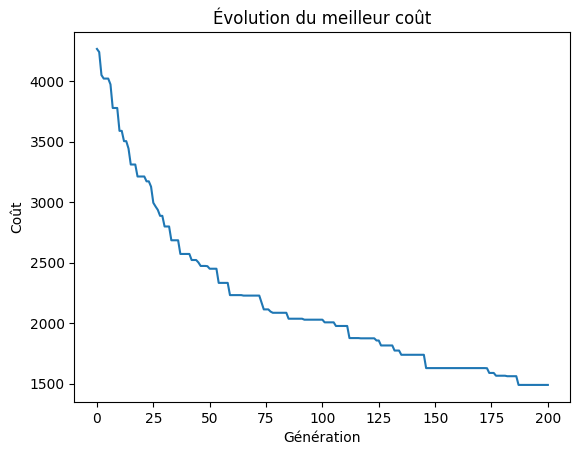


Meilleur chemin trouvé (extrait):
Départ: [1, 34, 17]...[39, 35, 1]
Longueur: 51 villes
Coût total: 1490
Chargement du fichier data/matrice_routes_ordre_75.csv...

Paramètres du problème:
- Nombre de villes: 75
- Points de collecte: [25, 37]
- Taille de la matrice: (75, 75)
Gen 0: Best=6289 Avg=6860.8
Gen 10: Best=5406 Avg=5601.6
Gen 20: Best=4904 Avg=5113.4
Gen 30: Best=4602 Avg=4734.0
Gen 40: Best=4164 Avg=4275.8
Gen 50: Best=3978 Avg=4058.3
Gen 60: Best=3837 Avg=3871.8
Gen 70: Best=3619 Avg=3634.8
Gen 80: Best=3485 Avg=3485.9
Gen 90: Best=3308 Avg=3334.8
Gen 100: Best=3248 Avg=3248.0
Gen 110: Best=3198 Avg=3198.2
Gen 120: Best=3091 Avg=3091.0
Gen 130: Best=2905 Avg=2905.2
Gen 140: Best=2905 Avg=2905.3
Gen 150: Best=2905 Avg=2905.0
Gen 160: Best=2804 Avg=2904.0
Gen 170: Best=2804 Avg=2805.1
Gen 180: Best=2745 Avg=2745.0
Gen 190: Best=2613 Avg=2613.0

Optimisation terminée en 3.35s
Meilleur coût trouvé: 2558
Solution valide: True


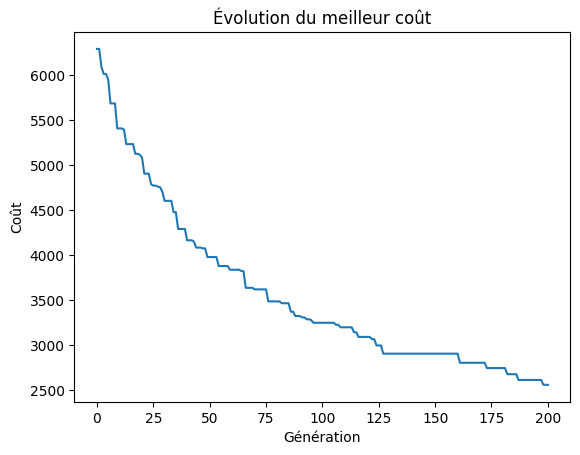


Meilleur chemin trouvé (extrait):
Départ: [1, 25, 56]...[33, 70, 1]
Longueur: 76 villes
Coût total: 2558
Chargement du fichier data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Gen 0: Best=8547 Avg=9164.6
Gen 10: Best=7858 Avg=8063.7
Gen 20: Best=7290 Avg=7411.1
Gen 30: Best=6599 Avg=6741.2
Gen 40: Best=6260 Avg=6324.9
Gen 50: Best=5734 Avg=5767.8
Gen 60: Best=5524 Avg=5643.5
Gen 70: Best=5148 Avg=5179.3
Gen 80: Best=5050 Avg=5096.9
Gen 90: Best=4918 Avg=4918.0
Gen 100: Best=4658 Avg=4692.1
Gen 110: Best=4530 Avg=4572.0
Gen 120: Best=4415 Avg=4415.0
Gen 130: Best=4337 Avg=4341.4
Gen 140: Best=4230 Avg=4230.0
Gen 150: Best=4138 Avg=4138.0
Gen 160: Best=3853 Avg=3991.7
Gen 170: Best=3853 Avg=3853.0
Gen 180: Best=3816 Avg=3831.2
Gen 190: Best=3736 Avg=3762.7

Optimisation terminée en 4.54s
Meilleur coût trouvé: 3635
Solution valide: True


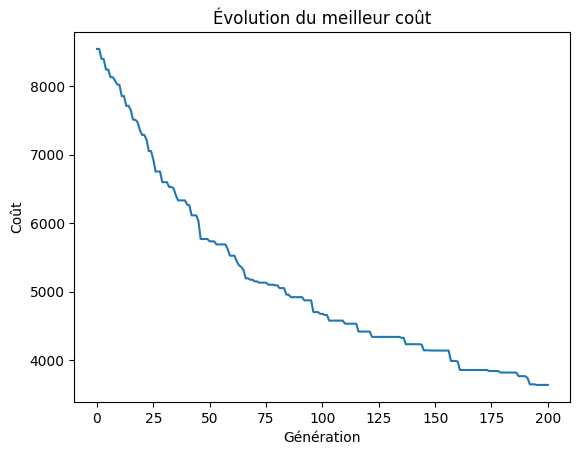


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 12]...[22, 94, 1]
Longueur: 101 villes
Coût total: 3635
Chargement du fichier data/matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [5, 6]
- Taille de la matrice: (10, 10)
Gen 0: Best=372 Avg=372.0
Gen 10: Best=372 Avg=372.0
Gen 20: Best=372 Avg=372.0
Gen 30: Best=372 Avg=373.4
Gen 40: Best=372 Avg=372.0
Gen 50: Best=372 Avg=373.4
Gen 60: Best=372 Avg=372.0
Gen 70: Best=372 Avg=373.4
Gen 80: Best=372 Avg=372.0
Gen 90: Best=372 Avg=372.0
Gen 100: Best=372 Avg=372.0
Gen 110: Best=372 Avg=372.0
Gen 120: Best=372 Avg=376.9
Gen 130: Best=372 Avg=379.9
Gen 140: Best=372 Avg=374.7
Gen 150: Best=372 Avg=372.0
Gen 160: Best=372 Avg=373.4
Gen 170: Best=372 Avg=372.0
Gen 180: Best=372 Avg=372.0
Gen 190: Best=372 Avg=373.6

Optimisation terminée en 0.58s
Meilleur coût trouvé: 372
Solution valide: True


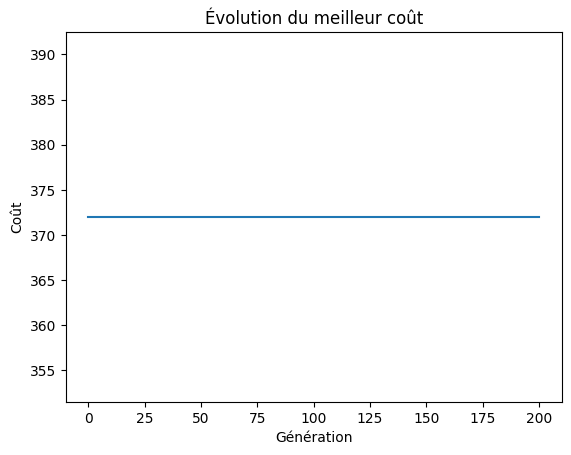


Meilleur chemin trouvé (extrait):
Départ: [1, 6, 9]...[5, 3, 1]
Longueur: 11 villes
Coût total: 372


In [11]:
if __name__ == "__main__":
    try:
        liste = ["data/matrice_routes_ordre_10.csv",
                 "data/matrice_routes_ordre_20.csv",
                 "data/matrice_routes_ordre_30.csv",
                 #r"data/matrice_routes_ordre_40_Difficile.csv", 
                    # Cette instance est particulièrement difficile à résoudre et prend beaucoup de temps pour être traitée.
                    # Nous avons choisi de commenter cette ligne pour éviter des temps de calcul trop longs lors de l'exécution du script. 
                    # Cependant, elle peut être décommentée et utilisée si nous disposons de plus de temps pour la résolution. 
                    # Cette instance peut permettre de tester la robustesse de l'algorithme, mais nécessite un temps d'exécution prolongé, particulièrement pour les méthodes exactes.
                 "data/matrice_routes_ordre_50.csv",
                 "data/matrice_routes_ordre_75.csv",
                 "data/matrice_routes_ordre_100.csv",
                 "data/matrice_routes_ordre_generation_aleatoire.csv"
                 ]
        for i in range(len(liste)):
            file_path = liste[i]  # Remplacez par votre chemin
            print(f"Chargement du fichier {file_path}...")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            
            print("\nParamètres du problème:")
            print(f"- Nombre de villes: {len(matrix)}")
            print(f"- Points de collecte: {collecte}")
            print(f"- Taille de la matrice: {matrix.shape}")
            
            # Résolution
            solver = GeneticTSP(matrix, collecte)
            solution, cost = solver.solve(
                population_size=100,
                generations=200,
                mutation_rate=0.2,
                elite_size=10
            )
            
            print("\nMeilleur chemin trouvé (extrait):")
            print(f"Départ: {solution[:3]}...{solution[-3:]}")
            print(f"Longueur: {len(solution)} villes")
            print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")

Source :

https://github.com/gregory-chatelier/tsp
https://www.malaspinas.academy/prog_seq/exercices/09_voyageur_commerce/index.html
https://igm.univ-mlv.fr/~dr/XPOSE2013/tleroux_genetic_algorithm/fonctionnement.html

## Le Recuit Simulé (Simulated Annealing)

Le **recuit simulé** est une **méthode d'optimisation stochastique** inspirée du processus physique de **recuit métallurgique**, où un métal est chauffé puis refroidi lentement pour atteindre une configuration minimale d'énergie.

### Principe
L'idée est d'explorer l'espace des solutions en acceptant non seulement les améliorations, mais aussi **certaines détériorations temporaires** de la solution. Cela permet d'**éviter les minima locaux**.

### Fonctionnement
1. **Initialisation** : On part d'une solution initiale et d'une température initiale élevée.
2. **Génération de voisin** : À chaque itération, une nouvelle solution voisine est générée.
3. **Évaluation** : Si elle est meilleure, on l'accepte. Si elle est pire, on l'accepte avec une probabilité qui diminue avec la température :
   \[
   P = e^{-\frac{\Delta E}{T}}
   \]
   où :
   - \( \Delta E \) est la variation de coût,
   - \( T \) est la température actuelle.
4. **Refroidissement** : La température est diminuée progressivement selon un **planning de refroidissement** (par exemple, \( T \leftarrow \alpha \cdot T \), avec \( 0 < \alpha < 1 \)).

### Avantages
- Évite les pièges des minima locaux.
- Facile à implémenter.
- Peu de paramètres à ajuster.

### Inconvénients
- Le choix du planning de refroidissement est crucial.
- Peut être lent à converger.

### Applications
- Problèmes combinatoires (comme le voyageur de commerce),
- Optimisation continue,
- Apprentissage automatique, etc.


In [12]:
# Cellule 1: Imports
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt
import math

In [13]:
# Cellule 2: Fonction de chargement des données
def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

## Classe principale du Recuit Simulé

Cette classe implémente l'algorithme de recuit simulé pour résoudre le problème de tournée de véhicules.

Le recuit simulé est une méta-heuristique inspirée du processus physique de recuit en métallurgie. L'algorithme:
1. Part d'une solution initiale
2. Explore l'espace des solutions en acceptant parfois des solutions moins bonnes (pour éviter les minima locaux)
3. Réduit progressivement la "température" pour converger vers une solution optimale

In [14]:
class SimulatedAnnealingTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_random_solution(self) -> List[int]:
        """Génère une solution aléatoire valide."""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                return path

    def get_neighbor(self, path: List[int]) -> List[int]:
        """Génère un voisin valide de la solution actuelle."""
        while True:
            new_path = path.copy()
            
            # On ne modifie pas le départ, l'arrivée ou les points de collecte contraints
            mutable_positions = list(range(1, len(path)-1))
            if len(path) > 3:
                mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
            if len(path) > 4:
                mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
                
            if len(mutable_positions) < 2:
                return path
                
            # Choisir un type de mouvement aléatoire
            move_type = random.choice(['swap', 'inversion', 'insertion'])
            
            if move_type == 'swap':
                # Échange de deux villes
                i, j = random.sample(mutable_positions, 2)
                new_path[i], new_path[j] = new_path[j], new_path[i]
                
            elif move_type == 'inversion':
                # Inversion d'une sous-séquence
                start, end = sorted(random.sample(mutable_positions, 2))
                new_path[start:end+1] = new_path[start:end+1][::-1]
                
            elif move_type == 'insertion':
                # Déplacement d'une ville à une autre position
                i = random.choice(mutable_positions)
                city = new_path.pop(i)
                j = random.choice([p for p in mutable_positions if p != i])
                new_path.insert(j, city)
            
            # Vérifier si le nouveau chemin est valide
            if self.is_valid_path(new_path):
                return new_path

    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.99,
             min_temp: float = 0.1, max_iter: int = 10000):
        """Algorithme de recuit simulé."""
        start_time = time.time()
        
        # Génération de la solution initiale
        current_solution = self._greedy_construction() or self.generate_random_solution()
        current_cost = self.calculate_cost(current_solution)
        
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        self.cost_history.append(current_cost)
        
        temp = initial_temp
        iteration = 0
        
        while temp > min_temp and iteration < max_iter:
            # Générer un voisin
            neighbor = self.get_neighbor(current_solution)
            neighbor_cost = self.calculate_cost(neighbor)
            
            # Calculer la différence de coût
            cost_diff = neighbor_cost - current_cost
            
            # Accepter ou rejeter le voisin
            if cost_diff < 0 or random.random() < math.exp(-cost_diff / temp):
                current_solution = neighbor
                current_cost = neighbor_cost
                
                # Mettre à jour la meilleure solution
                if current_cost < self.best_cost:
                    self.best_solution = current_solution.copy()
                    self.best_cost = current_cost
            
            # Enregistrer le meilleur coût à chaque itération
            self.cost_history.append(self.best_cost)
            
            # Refroidissement
            temp *= cooling_rate
            iteration += 1
            
            # Affichage progression
            if iteration % 100 == 0:
                print(f"Iter {iteration}: Temp={temp:.2f} Best={self.best_cost} Current={current_cost}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Itération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

## Validation des solutions

Cette partie implémente les méthodes pour valider les solutions et calculer leur coût.

- `is_valid_path`: Vérifie si un chemin respecte toutes les contraintes
- `calculate_cost`: Calcule le coût total d'une solution (longueur du trajet)

## Génération de solutions initiales

Deux méthodes pour générer des solutions initiales:
1. `_greedy_construction`: Approche gloutonne qui construit la solution pas à pas en choisissant toujours le meilleur mouvement local
2. `generate_random_solution`: Génère une solution aléatoire mais valide

Une bonne solution initiale peut accélérer la convergence de l'algorithme.

## Génération de voisins

La méthode `get_neighbor` génère des solutions voisines en utilisant trois opérations:
1. `swap`: Échange deux villes dans le parcours
2. `inversion`: Inverse une sous-séquence du parcours
3. `insertion`: Déplace une ville à une autre position

Ces opérations permettent d'explorer l'espace des solutions tout en garantissant que les solutions générées restent valides.

## Algorithme de Recuit Simulé

C'est le cœur de l'implémentation. L'algorithme:
1. Part d'une solution initiale
2. À chaque itération:
   - Génère un voisin
   - Décide de l'accepter ou non (en fonction de la température et de l'amélioration)
   - Réduit la température selon un taux de refroidissement
3. Garde trace de la meilleure solution trouvée

Les paramètres clés sont:
- `initial_temp`: Température initiale
- `cooling_rate`: Taux de refroidissement
- `min_temp`: Température minimale avant arrêt
- `max_iter`: Nombre maximum d'itérations

## Choix des paramètres pour l'heuristique de Recuit Simulé (Simulated Annealing)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants ont été choisis en fonction de l'échelle du problème. Chaque paramètre a un rôle précis pour garantir une bonne exploration de l'espace de recherche tout en favorisant la convergence vers des solutions optimales.

| Taille (nombre de villes) | Température initiale (`T_init`) | Température finale (`T_min`) | Taux de refroidissement (`cooling_rate`) | Nombre d'itérations par température |
|:---|:---|:---|:---|:---|
| 10  | 1000  | 1  | 0.95 | 50 |
| 20  | 2000  | 1  | 0.95 | 100 |
| 30  | 3000  | 1  | 0.95 | 150 |
| 40  | 4000  | 1  | 0.95 | 200 |
| 50  | 5000  | 1  | 0.95 | 250 |
| 75  | 7500  | 1  | 0.95 | 400 |
| 100 | 10000 | 1  | 0.95 | 500 |

### Explication des choix

1. **Température initiale (`T_init`)** :
   - La température initiale est choisie proportionnellement au nombre de villes. Cette température représente l'énergie initiale du système, et elle est élevée pour permettre une large exploration de l’espace de solutions. Plus il y a de villes, plus l'espace de recherche est grand, donc une température initiale plus élevée est nécessaire pour explorer efficacement cet espace. Par exemple, pour 10 villes, une température initiale de 1000 est suffisante pour commencer, tandis que pour 100 villes, une température initiale de 10000 est utilisée pour garantir une exploration approfondie dès le début.

2. **Température minimale (`T_min`)** :
   - La température minimale est fixée à 1, ce qui indique la fin du processus de recuit. Lorsque la température atteint cette valeur, l'algorithme arrête de faire des changements significatifs dans les solutions, marquant la fin de l'optimisation. Le choix d'une température minimale de 1 est un compromis entre un arrêt prématuré (si la température est trop élevée) et un refroidissement trop lent (si la température minimale est trop basse).

3. **Taux de refroidissement (`cooling_rate`)** :
   - Le taux de refroidissement est fixé à 0.95, ce qui permet un refroidissement progressif de la température. Un taux de refroidissement trop rapide pourrait entraîner une convergence prématurée vers des solutions sous-optimales, tandis qu'un taux trop lent pourrait prolonger inutilement le calcul sans amélioration significative des résultats. Le choix de 0.95 permet d'équilibrer l'exploration initiale avec une exploitation plus ciblée des meilleures solutions trouvées à mesure que la température diminue.

4. **Nombre d'itérations par température** :
   - Le nombre d'itérations par température détermine combien de fois l'algorithme explore les solutions à une température donnée avant de la réduire. Ce nombre est augmenté avec la taille du problème pour garantir que chaque palier de température soit suffisamment exploré avant de passer au suivant. Cela permet à l'algorithme de mieux exploiter chaque température et de trouver des solutions plus solides à chaque étape de refroidissement. Pour de petits problèmes (10 villes), 50 itérations suffisent, mais pour des problèmes plus grands (100 villes), 500 itérations sont nécessaires pour bien explorer chaque palier.

### Pourquoi ces choix ?

- **Exploration vs. exploitation** : Le processus de recuit simulé repose sur un équilibre entre exploration (recherche de nouvelles solutions) et exploitation (amélioration des solutions existantes). Les paramètres sont conçus pour favoriser une exploration initiale large (avec une température élevée) tout en garantissant une exploitation efficace des bonnes solutions au fur et à mesure que la température diminue.
  
- **Adaptation à la taille du problème** : Les paramètres évoluent avec la taille du problème pour garantir une recherche suffisamment large et approfondie. Pour les petits problèmes, un refroidissement plus rapide et moins d'itérations sont suffisants, tandis que pour les grands problèmes, un refroidissement plus lent et un nombre d'itérations plus élevé sont nécessaires pour garantir une convergence adéquate.

Ces choix sont cruciaux pour l'efficacité de l'algorithme de recuit simulé, permettant une recherche efficace dans l'espace de solutions tout en évitant les pièges des optima locaux, en particulier pour des problèmes de grande taille.


## Exemple d'utilisation de l'algorithme de Recuit Simulé

Cette section présente un exemple concret d'utilisation de l'algorithme de recuit simulé pour résoudre un problème d'optimisation, en ajustant les paramètres afin de s'adapter aux spécificités de l'instance du problème.

### Paramètres utilisés :
- **initial_temp** : La température initiale contrôle l'exploration du problème. Plus elle est élevée, plus l'algorithme accepte facilement des solutions moins bonnes au début, ce qui permet une exploration plus large de l'espace de solutions. Une température trop basse pourrait bloquer l'algorithme dans une solution locale suboptimale dès le départ. En fonction de la taille du problème, la température initiale peut être ajustée pour garantir une exploration suffisante. Par exemple, pour un petit problème avec 10 villes, une température initiale de 1000 est utilisée, tandis que pour un problème avec 100 villes, une température initiale de 10000 permet d'explorer un espace de recherche plus vaste.

- **cooling_rate** : Le taux de refroidissement détermine à quelle vitesse la température diminue au fil des itérations. Plus ce taux est proche de 1, plus le refroidissement sera lent, ce qui permet à l'algorithme de continuer à explorer les solutions pendant plus de temps avant de se concentrer sur l'exploitation des meilleures solutions trouvées. En revanche, un taux de refroidissement plus élevé entraînerait un refroidissement rapide, ce qui risquerait de limiter l'exploration de solutions nouvelles. Le taux de refroidissement est souvent fixé à une valeur proche de 0.95 pour garantir un bon équilibre entre exploration et exploitation.

- **min_temp** : La température minimale marque la fin du processus de recuit simulé. Lorsque la température atteint cette valeur, l'algorithme arrête l'exploration. La température minimale est souvent fixée à 1 pour éviter des boucles d'exploration inutiles lorsque les mouvements deviennent insignifiants. Si la température est trop élevée à ce stade, l'algorithme peut encore accepter des changements de solution trop importants, rendant l'optimisation moins efficace.

- **max_iter** : Le nombre maximum d'itérations permet de limiter le nombre de passes que l'algorithme effectue avant de s'arrêter, même si la température minimale n'est pas atteinte. Ce paramètre est utilisé pour éviter que l'algorithme ne s'exécute indéfiniment, notamment sur des instances complexes où la convergence peut être lente. Ce paramètre est ajusté en fonction de la taille du problème, augmentant avec le nombre de villes pour garantir que l'algorithme a suffisamment de temps pour explorer l'espace de solutions.

### Adaptation des paramètres en fonction de la taille du problème
Afin d'optimiser l'algorithme pour différentes tailles de problèmes, les paramètres sont ajustés de la manière suivante <u>**à la fin du NoteBook**</u>:
- **initial_temp** : La température initiale est augmentée proportionnellement à la taille du problème pour assurer une exploration plus large.
- **cooling_rate** : Le taux de refroidissement reste généralement constant, mais peut être ajusté pour s'assurer qu'il n'est ni trop rapide ni trop lent pour la taille du problème.
- **min_temp** : Fixée à 1 pour éviter une fin prématurée du processus d'optimisation.
- **max_iter** : Le nombre d'itérations est augmenté pour les problèmes plus grands, afin de garantir que l'algorithme a suffisamment d'opportunités pour converger vers une solution optimale.


Chargement du fichier data/matrice_routes_ordre_10.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [3, 7]
- Taille de la matrice: (10, 10)
Iter 100: Temp=6057.70 Best=638 Current=880
Iter 200: Temp=3669.58 Best=638 Current=982
Iter 300: Temp=2222.92 Best=638 Current=1034
Iter 400: Temp=1346.58 Best=590 Current=933
Iter 500: Temp=815.72 Best=590 Current=994
Iter 600: Temp=494.14 Best=590 Current=660
Iter 700: Temp=299.33 Best=590 Current=702
Iter 800: Temp=181.33 Best=590 Current=738
Iter 900: Temp=109.84 Best=590 Current=827
Iter 1000: Temp=66.54 Best=541 Current=797
Iter 1100: Temp=40.31 Best=541 Current=541
Iter 1200: Temp=24.42 Best=541 Current=703
Iter 1300: Temp=14.79 Best=541 Current=541
Iter 1400: Temp=8.96 Best=541 Current=541
Iter 1500: Temp=5.43 Best=541 Current=541
Iter 1600: Temp=3.29 Best=541 Current=541
Iter 1700: Temp=1.99 Best=541 Current=541
Iter 1800: Temp=1.21 Best=541 Current=541
Iter 1900: Temp=0.73 Best=541 Current=541
Iter 2000: Temp=

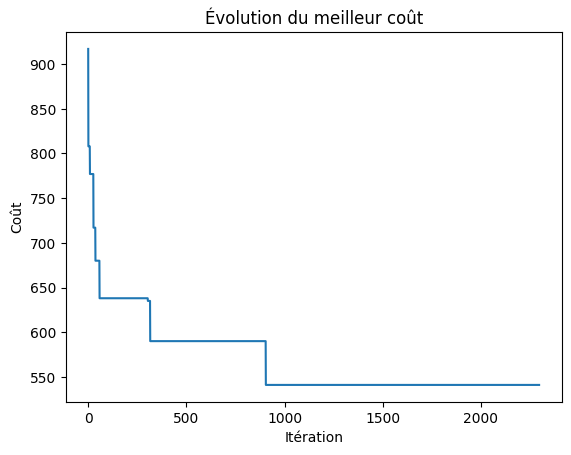


Meilleur chemin trouvé (extrait):
Départ: [1, 7, 2]...[9, 10, 1]
Longueur: 11 villes
Coût total: 541
Chargement du fichier data/matrice_routes_ordre_20.csv...

Paramètres du problème:
- Nombre de villes: 20
- Points de collecte: [5, 13]
- Taille de la matrice: (20, 20)
Iter 100: Temp=6057.70 Best=1016 Current=2265
Iter 200: Temp=3669.58 Best=1016 Current=2574
Iter 300: Temp=2222.92 Best=1016 Current=2173
Iter 400: Temp=1346.58 Best=1016 Current=2595
Iter 500: Temp=815.72 Best=1016 Current=2085
Iter 600: Temp=494.14 Best=1016 Current=2181
Iter 700: Temp=299.33 Best=1016 Current=2295
Iter 800: Temp=181.33 Best=1016 Current=2337
Iter 900: Temp=109.84 Best=1016 Current=2251
Iter 1000: Temp=66.54 Best=1016 Current=1616
Iter 1100: Temp=40.31 Best=1016 Current=1455
Iter 1200: Temp=24.42 Best=1016 Current=1282
Iter 1300: Temp=14.79 Best=1016 Current=1340
Iter 1400: Temp=8.96 Best=1016 Current=1178
Iter 1500: Temp=5.43 Best=1016 Current=1178
Iter 1600: Temp=3.29 Best=1016 Current=1178
Iter 170

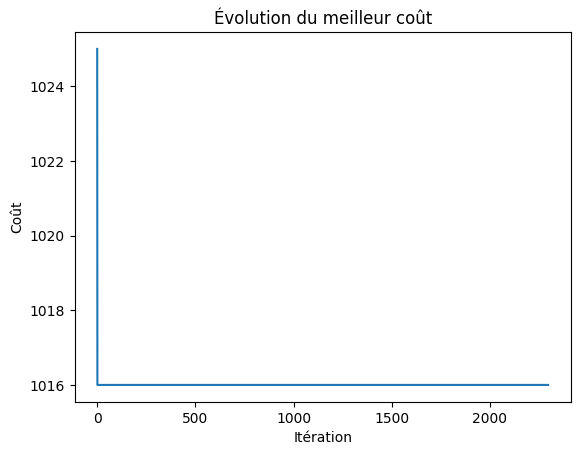


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 5]...[10, 7, 1]
Longueur: 21 villes
Coût total: 1016
Chargement du fichier data/matrice_routes_ordre_30.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [5, 14]
- Taille de la matrice: (30, 30)
Iter 100: Temp=6057.70 Best=1056 Current=2926
Iter 200: Temp=3669.58 Best=1056 Current=3303
Iter 300: Temp=2222.92 Best=1056 Current=2950
Iter 400: Temp=1346.58 Best=1056 Current=2711
Iter 500: Temp=815.72 Best=1056 Current=3188
Iter 600: Temp=494.14 Best=1056 Current=2925
Iter 700: Temp=299.33 Best=1056 Current=3134
Iter 800: Temp=181.33 Best=1056 Current=2167
Iter 900: Temp=109.84 Best=1056 Current=2623
Iter 1000: Temp=66.54 Best=1056 Current=2545
Iter 1100: Temp=40.31 Best=1056 Current=1914
Iter 1200: Temp=24.42 Best=1056 Current=1664
Iter 1300: Temp=14.79 Best=1056 Current=1514
Iter 1400: Temp=8.96 Best=1056 Current=1388
Iter 1500: Temp=5.43 Best=1056 Current=1371
Iter 1600: Temp=3.29 Best=1056 Current=1310
Iter 1

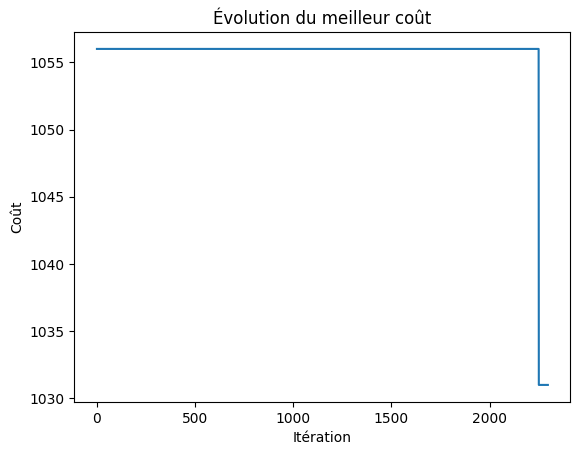


Meilleur chemin trouvé (extrait):
Départ: [1, 5, 23]...[21, 12, 1]
Longueur: 31 villes
Coût total: 1031
Chargement du fichier data/matrice_routes_ordre_50.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [34, 9]
- Taille de la matrice: (50, 50)
Iter 100: Temp=6057.70 Best=4375 Current=5301
Iter 200: Temp=3669.58 Best=4335 Current=4449
Iter 300: Temp=2222.92 Best=4011 Current=4385
Iter 400: Temp=1346.58 Best=4011 Current=4575
Iter 500: Temp=815.72 Best=4011 Current=5096
Iter 600: Temp=494.14 Best=4011 Current=4764
Iter 700: Temp=299.33 Best=3983 Current=4693
Iter 800: Temp=181.33 Best=3379 Current=3677
Iter 900: Temp=109.84 Best=3379 Current=3930
Iter 1000: Temp=66.54 Best=3190 Current=3274
Iter 1100: Temp=40.31 Best=2249 Current=2302
Iter 1200: Temp=24.42 Best=2205 Current=2205
Iter 1300: Temp=14.79 Best=2141 Current=2195
Iter 1400: Temp=8.96 Best=1779 Current=1779
Iter 1500: Temp=5.43 Best=1720 Current=1723
Iter 1600: Temp=3.29 Best=1609 Current=1609
Iter 

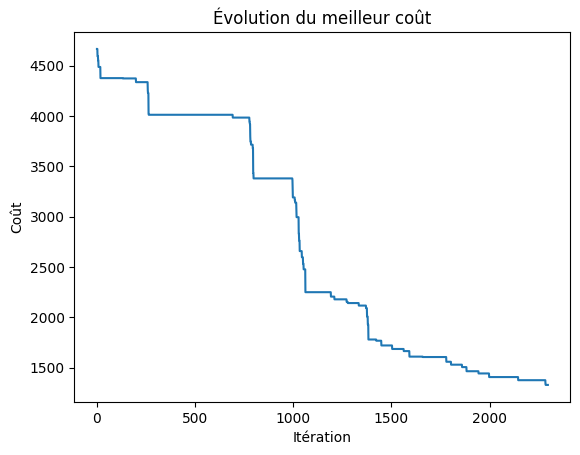


Meilleur chemin trouvé (extrait):
Départ: [1, 9, 10]...[48, 16, 1]
Longueur: 51 villes
Coût total: 1328
Chargement du fichier data/matrice_routes_ordre_75.csv...

Paramètres du problème:
- Nombre de villes: 75
- Points de collecte: [25, 37]
- Taille de la matrice: (75, 75)
Iter 100: Temp=6057.70 Best=6507 Current=7889
Iter 200: Temp=3669.58 Best=6454 Current=7062
Iter 300: Temp=2222.92 Best=6454 Current=7109
Iter 400: Temp=1346.58 Best=6454 Current=7102
Iter 500: Temp=815.72 Best=6302 Current=7250
Iter 600: Temp=494.14 Best=6001 Current=7129
Iter 700: Temp=299.33 Best=6001 Current=8208
Iter 800: Temp=181.33 Best=6001 Current=6981
Iter 900: Temp=109.84 Best=6001 Current=6574
Iter 1000: Temp=66.54 Best=5210 Current=5210
Iter 1100: Temp=40.31 Best=4303 Current=4303
Iter 1200: Temp=24.42 Best=3613 Current=3613
Iter 1300: Temp=14.79 Best=3284 Current=3284
Iter 1400: Temp=8.96 Best=3284 Current=3288
Iter 1500: Temp=5.43 Best=3077 Current=3077
Iter 1600: Temp=3.29 Best=2849 Current=2849
Iter

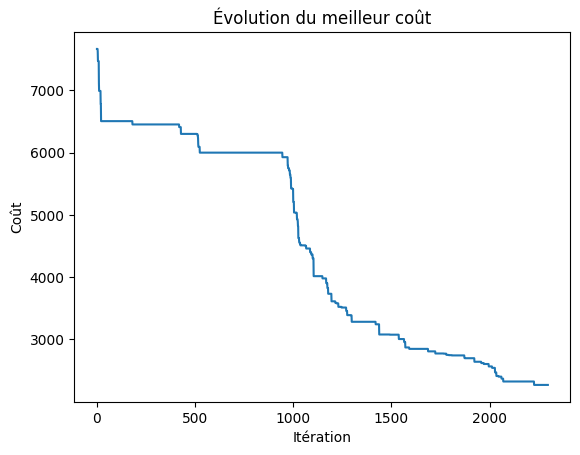


Meilleur chemin trouvé (extrait):
Départ: [1, 25, 29]...[18, 31, 1]
Longueur: 76 villes
Coût total: 2270
Chargement du fichier data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Iter 100: Temp=6057.70 Best=8892 Current=10404
Iter 200: Temp=3669.58 Best=8892 Current=9654
Iter 300: Temp=2222.92 Best=8532 Current=8532
Iter 400: Temp=1346.58 Best=8167 Current=9544
Iter 500: Temp=815.72 Best=7879 Current=8327
Iter 600: Temp=494.14 Best=7759 Current=9586
Iter 700: Temp=299.33 Best=7759 Current=8896
Iter 800: Temp=181.33 Best=7673 Current=7702
Iter 900: Temp=109.84 Best=6687 Current=6831
Iter 1000: Temp=66.54 Best=6687 Current=7189
Iter 1100: Temp=40.31 Best=6344 Current=6475
Iter 1200: Temp=24.42 Best=5134 Current=5134
Iter 1300: Temp=14.79 Best=4649 Current=4649
Iter 1400: Temp=8.96 Best=4509 Current=4509
Iter 1500: Temp=5.43 Best=4059 Current=4059
Iter 1600: Temp=3.29 Best=3655 Current=365

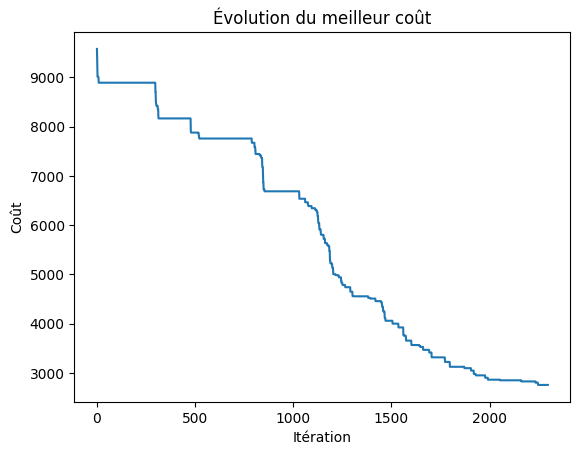


Meilleur chemin trouvé (extrait):
Départ: [1, 46, 48]...[60, 94, 1]
Longueur: 101 villes
Coût total: 2756
Chargement du fichier data/matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [5, 6]
- Taille de la matrice: (10, 10)
Iter 100: Temp=6057.70 Best=372 Current=1007
Iter 200: Temp=3669.58 Best=372 Current=782
Iter 300: Temp=2222.92 Best=372 Current=839
Iter 400: Temp=1346.58 Best=372 Current=949
Iter 500: Temp=815.72 Best=372 Current=885
Iter 600: Temp=494.14 Best=372 Current=749
Iter 700: Temp=299.33 Best=372 Current=851
Iter 800: Temp=181.33 Best=372 Current=668
Iter 900: Temp=109.84 Best=372 Current=690
Iter 1000: Temp=66.54 Best=372 Current=765
Iter 1100: Temp=40.31 Best=372 Current=372
Iter 1200: Temp=24.42 Best=372 Current=372
Iter 1300: Temp=14.79 Best=372 Current=372
Iter 1400: Temp=8.96 Best=372 Current=372
Iter 1500: Temp=5.43 Best=372 Current=372
Iter 1600: Temp=3.29 Best=372 Current=372
Iter 1700: Temp=1

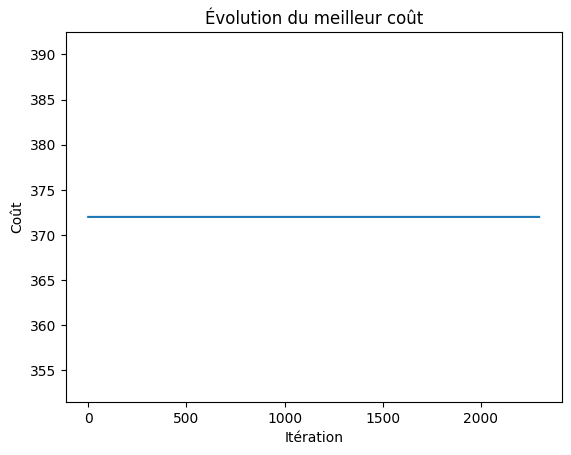


Meilleur chemin trouvé (extrait):
Départ: [1, 6, 9]...[5, 3, 1]
Longueur: 11 villes
Coût total: 372


In [16]:
# Cellule 8: Exemple d'utilisation
if __name__ == "__main__":
    try:
        liste = ["data/matrice_routes_ordre_10.csv",
                 "data/matrice_routes_ordre_20.csv",
                 "data/matrice_routes_ordre_30.csv",
                 #r"data/matrice_routes_ordre_40_Difficile.csv", 
                    # Cette instance est particulièrement difficile à résoudre et prend beaucoup de temps pour être traitée.
                    # Nous avons choisi de commenter cette ligne pour éviter des temps de calcul trop longs lors de l'exécution du script. 
                    # Cependant, elle peut être décommentée et utilisée si nous disposons de plus de temps pour la résolution. 
                    # Cette instance peut permettre de tester la robustesse de l'algorithme, mais nécessite un temps d'exécution prolongé, particulièrement pour les méthodes exactes.
                 "data/matrice_routes_ordre_50.csv",
                 "data/matrice_routes_ordre_75.csv",
                 "data/matrice_routes_ordre_100.csv",
                 "data/matrice_routes_ordre_generation_aleatoire.csv"
                 ]
        for i in range(len(liste)):
            file_path = liste[i]  # Remplacez par votre chemin
            print(f"Chargement du fichier {file_path}...")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            
            print("\nParamètres du problème:")
            print(f"- Nombre de villes: {len(matrix)}")
            print(f"- Points de collecte: {collecte}")
            print(f"- Taille de la matrice: {matrix.shape}")
            
            # Résolution
            solver = SimulatedAnnealingTSP(matrix, collecte)
            solution, cost = solver.solve(
                initial_temp=10000,
                cooling_rate=0.995,
                min_temp=0.1,
                max_iter=5000
            )
            
            print("\nMeilleur chemin trouvé (extrait):")
            print(f"Départ: {solution[:3]}...{solution[-3:]}")
            print(f"Longueur: {len(solution)} villes")
            print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")

## Sources :

- https://www.i2m.univ-amu.fr/perso/jean-philippe.preaux/PDF/pdf_proteges/OptimisationCombinatoire/Metaheuristiques2.pdf
- http://www.lps.ens.fr/~weisbuch/livre/b9.html

# Plan d'Expérience et Étude Expérimentale

L'objectif de cette étude est de comparer la performance de différentes méta-heuristiques, avec des paramètres adaptés à chaque instance, à celle d'une méthode exacte, afin de déterminer la méta-heuristique la plus adaptée à notre problème. Pour ce faire, un plan d'expérience a été défini, où l'impact du nombre de villes (taille du problème) sur la qualité des solutions est étudié. Chaque taille de problème est testée à travers plusieurs exécutions indépendantes (5x) afin de garantir la représentativité statistique des résultats.

L'étude expérimentale se concentre sur l'analyse de la qualité des solutions obtenues. Les paramètres de chaque méta-heuristique sont ajustés spécifiquement pour chaque instance afin d'optimiser les performances. Les résultats seront présentés à l'aide d'indicateurs statistiques adaptés tels que la moyenne et l'écart-type, et illustrés par des courbes d'évolution. Cela nous permettra d'analyser comment la taille des instances influence la capacité des différentes méthodes à trouver des solutions de qualité tout en respectant les contraintes de temps. L'objectif est de tirer des conclusions sur la performance relative de chaque méta-heuristique, afin de déterminer celle qui est la plus adaptée à notre problème en fonction des différentes tailles de problèmes étudiées.



Loading file: data/matrice_routes_ordre_10.csv

Problem parameters:
- Number of cities: 10
- Collection points: [3, 7]

Using optimized parameters for this matrix size:
- Genetic: pop_size=15, generations=30
- Simulated Annealing: initial_temp=800, cooling_rate=0.9
- Ant Colony: ants=5, iterations=30

Starting comparison...

=== Testing Genetic algorithm ===
Run 1: Cost=465 Time=0.02s Valid=True
Run 2: Cost=441 Time=0.02s Valid=True
Run 3: Cost=458 Time=0.02s Valid=True
Run 4: Cost=541 Time=0.02s Valid=True
Run 5: Cost=458 Time=0.02s Valid=True

=== Testing Simulated Annealing algorithm ===
Run 1: Cost=510 Time=0.00s Valid=True
Run 2: Cost=713 Time=0.00s Valid=True
Run 3: Cost=687 Time=0.00s Valid=True
Run 4: Cost=632 Time=0.00s Valid=True
Run 5: Cost=465 Time=0.00s Valid=True

=== Testing Ant Colony algorithm ===
Run 1: Cost=513 Time=0.05s Valid=True
Run 2: Cost=596 Time=0.05s Valid=True
Run 3: Cost=509 Time=0.05s Valid=True
Run 4: Cost=509 Time=0.05s Valid=True
Run 5: Cost=516 Time=

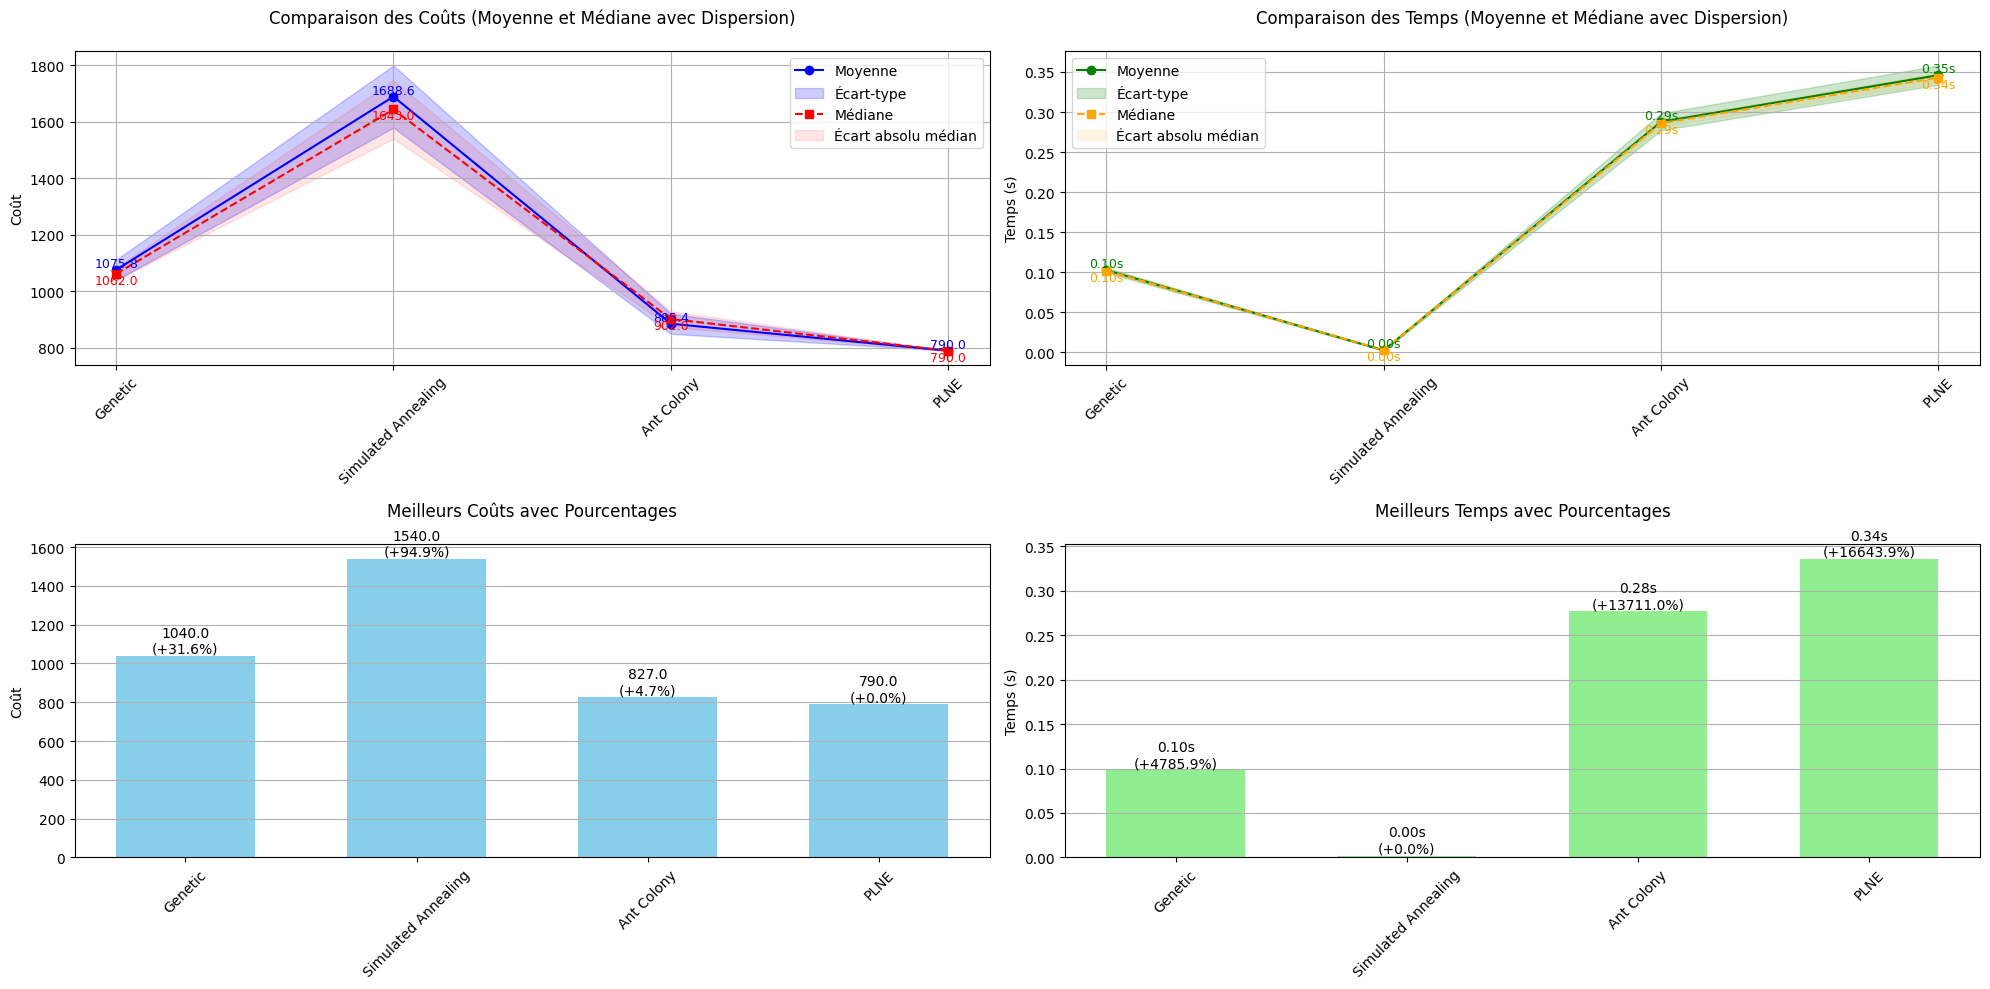


BEST SOLUTIONS FOUND:

Genetic:
Cost: 1040.0
Path: [1, 13, 9, '...', 15, 12, 1]

Simulated Annealing:
Cost: 1540.0
Path: [1, 13, 20, '...', 10, 18, 1]

Ant Colony:
Cost: 827.0
Path: [1, 13, 5, '...', 3, 16, 1]

PLNE:
Cost: 790.0
Path: [1, 13, 5, '...', 3, 16, 1]

Loading file: data/matrice_routes_ordre_30.csv

Problem parameters:
- Number of cities: 30
- Collection points: [5, 14]

Using optimized parameters for this matrix size:
- Genetic: pop_size=40, generations=100
- Simulated Annealing: initial_temp=2500, cooling_rate=0.93
- Ant Colony: ants=12, iterations=80

Starting comparison...

=== Testing Genetic algorithm ===
Run 1: Cost=1176 Time=0.38s Valid=True
Run 2: Cost=1114 Time=0.39s Valid=True
Run 3: Cost=976 Time=0.38s Valid=True
Run 4: Cost=966 Time=0.41s Valid=True
Run 5: Cost=1168 Time=0.38s Valid=True

=== Testing Simulated Annealing algorithm ===
Run 1: Cost=1997 Time=0.00s Valid=True
Run 2: Cost=1728 Time=0.00s Valid=True
Run 3: Cost=2064 Time=0.00s Valid=True
Run 4: Cost=

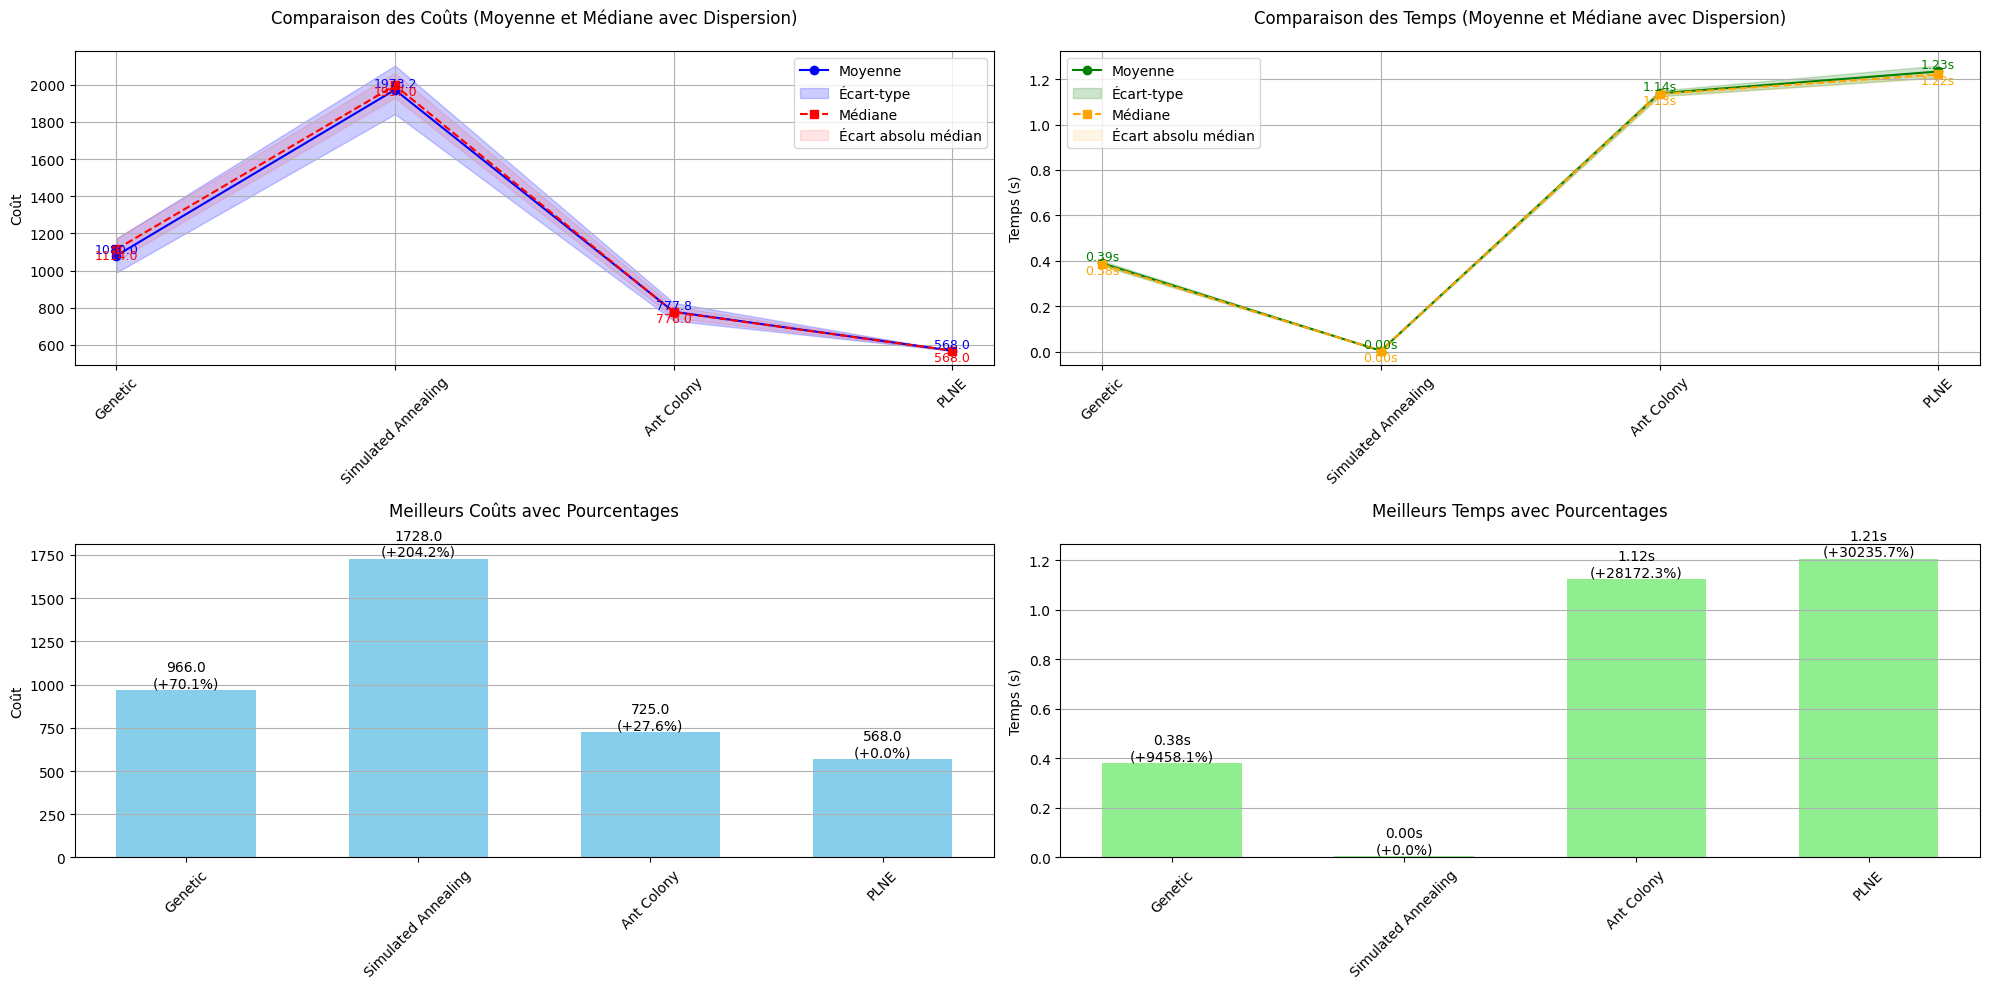


BEST SOLUTIONS FOUND:

Genetic:
Cost: 966.0
Path: [1, 5, 30, '...', 16, 7, 1]

Simulated Annealing:
Cost: 1728.0
Path: [1, 5, 14, '...', 13, 23, 1]

Ant Colony:
Cost: 725.0
Path: [1, 5, 23, '...', 12, 26, 1]

PLNE:
Cost: 568.0
Path: [1, 5, 23, '...', 9, 26, 1]

Loading file: data/matrice_routes_ordre_50.csv

Problem parameters:
- Number of cities: 50
- Collection points: [34, 9]

Using optimized parameters for this matrix size:
- Genetic: pop_size=80, generations=200
- Simulated Annealing: initial_temp=4500, cooling_rate=0.95
- Ant Colony: ants=18, iterations=120

Starting comparison...

=== Testing Genetic algorithm ===
Run 1: Cost=1219 Time=2.36s Valid=True
Run 2: Cost=1385 Time=2.45s Valid=True
Run 3: Cost=1321 Time=2.28s Valid=True
Run 4: Cost=1386 Time=2.28s Valid=True
Run 5: Cost=1287 Time=2.33s Valid=True

=== Testing Simulated Annealing algorithm ===
Run 1: Cost=3727 Time=0.01s Valid=True
Run 2: Cost=3609 Time=0.01s Valid=True
Run 3: Cost=3776 Time=0.01s Valid=True
Run 4: Cost

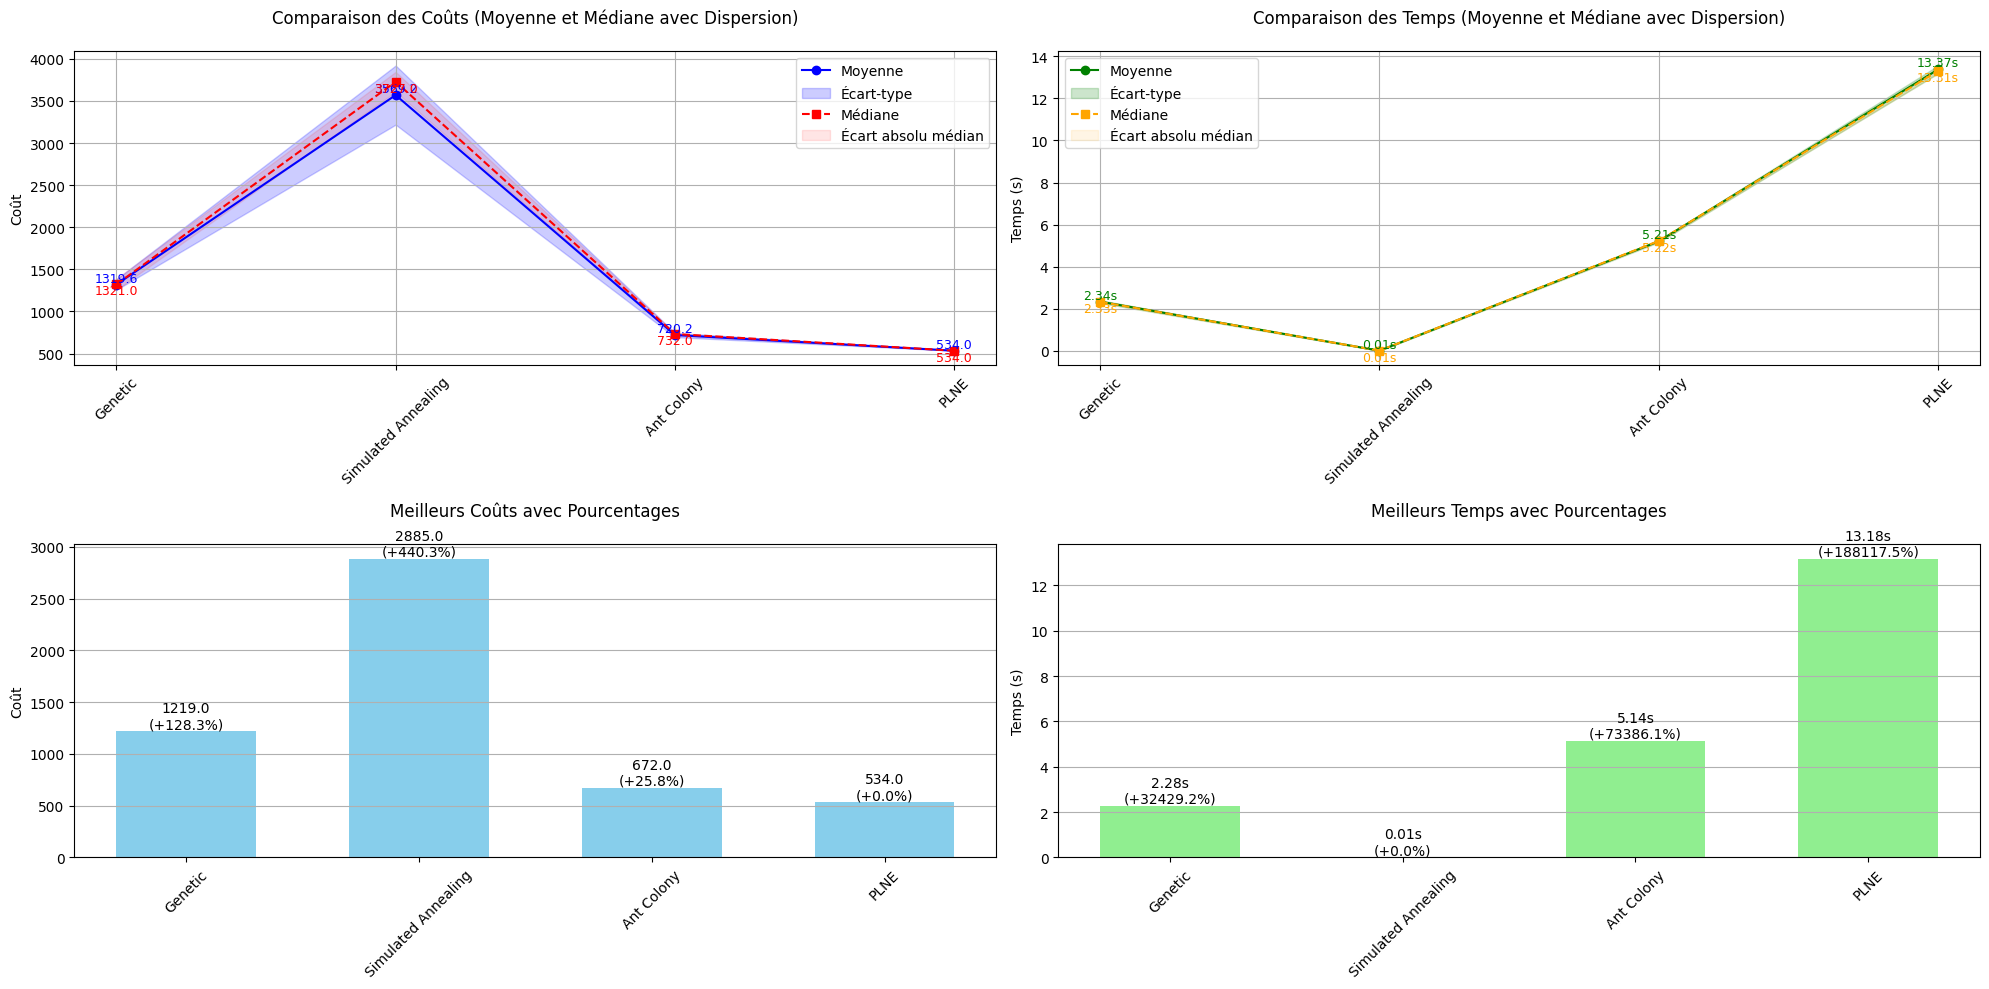


BEST SOLUTIONS FOUND:

Genetic:
Cost: 1219.0
Path: [1, 9, 41, '...', 11, 50, 1]

Simulated Annealing:
Cost: 2885.0
Path: [1, 34, 26, '...', 8, 46, 1]

Ant Colony:
Cost: 672.0
Path: [1, 34, 29, '...', 16, 49, 1]

PLNE:
Cost: 534.0
Path: [1, 34, 29, '...', 27, 36, 1]

Loading file: data/matrice_routes_ordre_75.csv

Problem parameters:
- Number of cities: 75
- Collection points: [25, 37]

Using optimized parameters for this matrix size:
- Genetic: pop_size=120, generations=300
- Simulated Annealing: initial_temp=7000, cooling_rate=0.96
- Ant Colony: ants=25, iterations=150

Starting comparison...

=== Testing Genetic algorithm ===
Run 1: Cost=1550 Time=7.92s Valid=True
Run 2: Cost=1848 Time=8.37s Valid=True
Run 3: Cost=1815 Time=8.02s Valid=True
Run 4: Cost=1634 Time=8.20s Valid=True
Run 5: Cost=1965 Time=8.57s Valid=True

=== Testing Simulated Annealing algorithm ===
Run 1: Cost=5690 Time=0.01s Valid=True
Run 2: Cost=5876 Time=0.02s Valid=True
Run 3: Cost=5763 Time=0.01s Valid=True
Run 

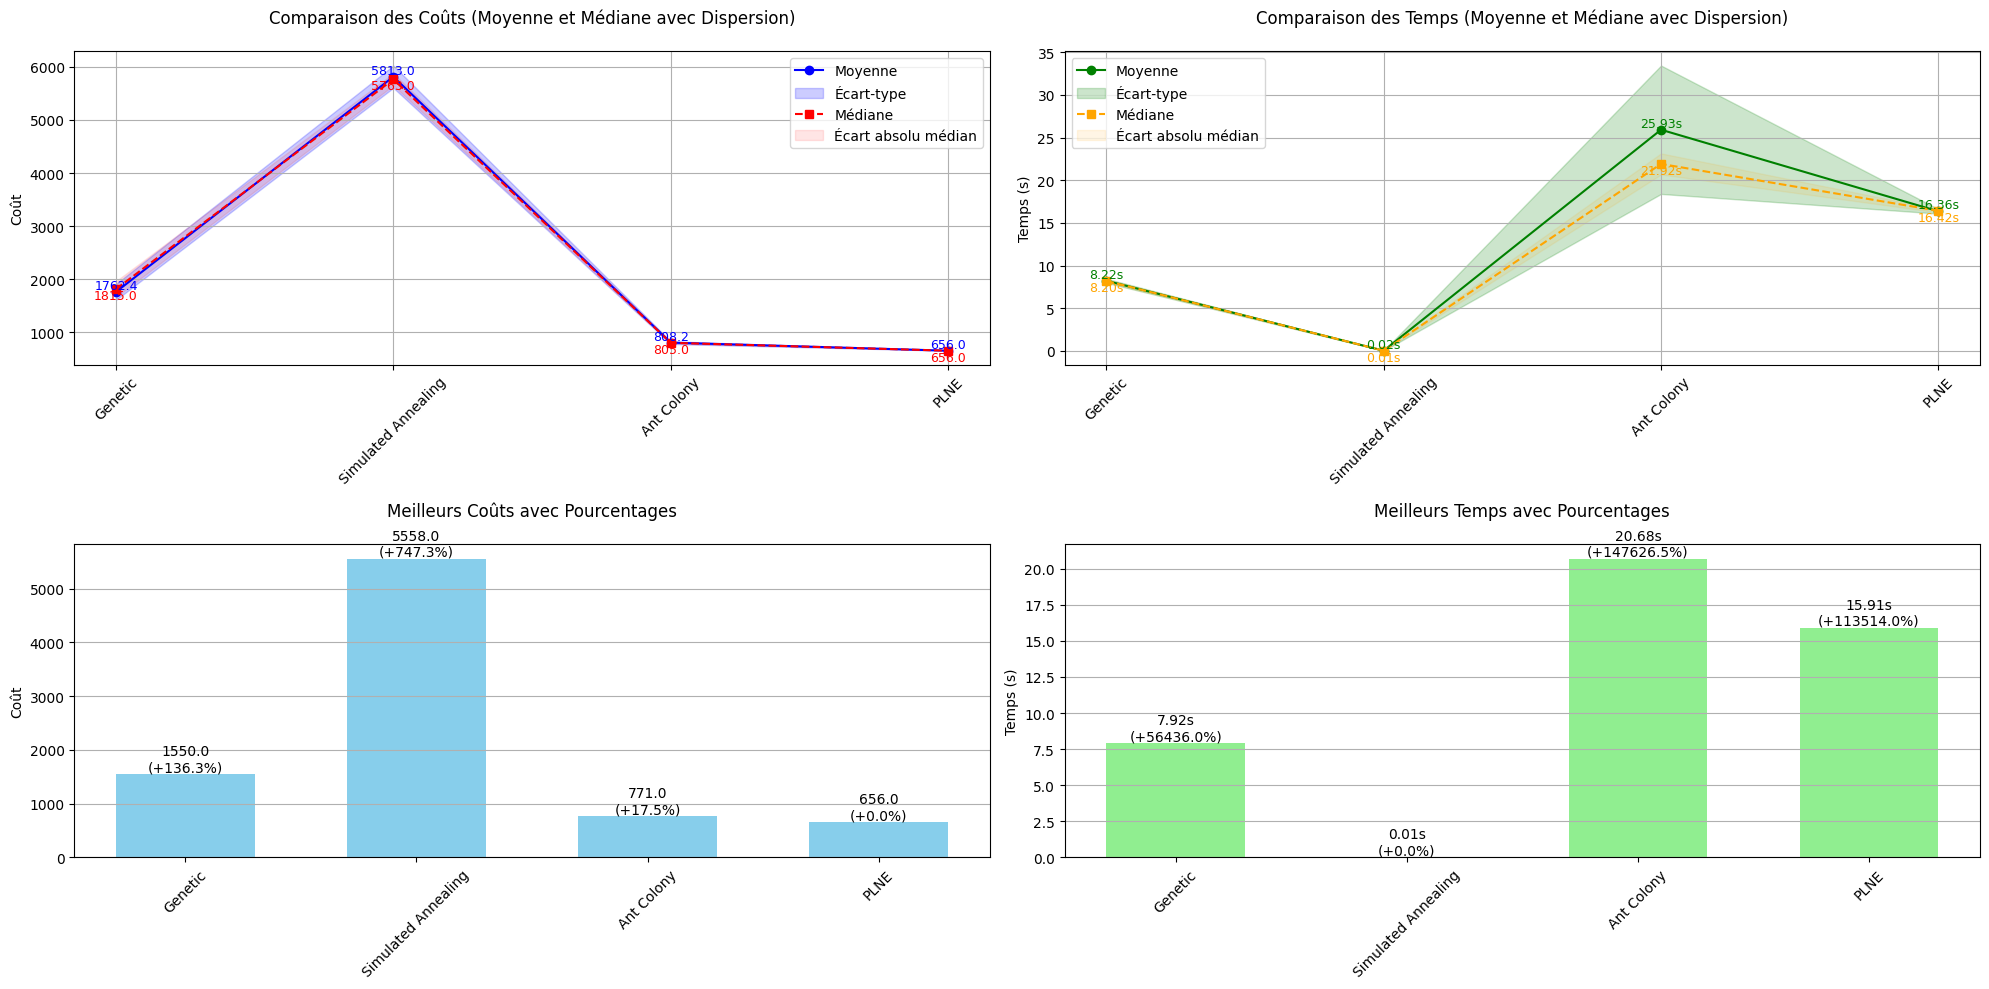


BEST SOLUTIONS FOUND:

Genetic:
Cost: 1550.0
Path: [1, 25, 22, '...', 6, 59, 1]

Simulated Annealing:
Cost: 5558.0
Path: [1, 25, 17, '...', 50, 67, 1]

Ant Colony:
Cost: 771.0
Path: [1, 25, 28, '...', 22, 59, 1]

PLNE:
Cost: 656.0
Path: [1, 25, 28, '...', 69, 70, 1]

Loading file: data/matrice_routes_ordre_100.csv

Problem parameters:
- Number of cities: 100
- Collection points: [46, 13]

Using optimized parameters for this matrix size:
- Genetic: pop_size=150, generations=400
- Simulated Annealing: initial_temp=9000, cooling_rate=0.97
- Ant Colony: ants=30, iterations=180

Starting comparison...

=== Testing Genetic algorithm ===
Run 1: Cost=2053 Time=23.26s Valid=True
Run 2: Cost=2220 Time=25.21s Valid=True
Run 3: Cost=2479 Time=25.04s Valid=True


In [ ]:
# Import des bibliothèques nécessaires
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
import pandas as pd
from tabulate import tabulate
from matplotlib.ticker import PercentFormatter

# ======================================================================
# PARAMÈTRES OPTIMAUX PAR TAILLE DE MATRICE
# ======================================================================
optimal_parameters = {
    10: {
        "GA": {"population_size": 15, "generations": 30, "crossover_rate": 0.85, "mutation_rate": 0.25, "elite_size": 2},
        "SA": {"initial_temp": 800, "cooling_rate": 0.9, "n_iterations_per_temp": 30, "max_time": 10},
        "ACO": {"num_ants": 5, "iterations": 30, "alpha": 0.8, "beta": 2, "evaporation_rate": 0.6, "Q": 80, "max_time": 5}
    },
    20: {
        "GA": {"population_size": 25, "generations": 60, "crossover_rate": 0.85, "mutation_rate": 0.2, "elite_size": 3},
        "SA": {"initial_temp": 1500, "cooling_rate": 0.92, "n_iterations_per_temp": 60, "max_time": 20},
        "ACO": {"num_ants": 8, "iterations": 50, "alpha": 0.9, "beta": 3, "evaporation_rate": 0.5, "Q": 90, "max_time": 10}
    },
    30: {
        "GA": {"population_size": 40, "generations": 100, "crossover_rate": 0.8, "mutation_rate": 0.15, "elite_size": 5},
        "SA": {"initial_temp": 2500, "cooling_rate": 0.93, "n_iterations_per_temp": 100, "max_time": 30},
        "ACO": {"num_ants": 12, "iterations": 80, "alpha": 1, "beta": 4, "evaporation_rate": 0.4, "Q": 100, "max_time": 15}
    },
    40: {
        "GA": {"population_size": 60, "generations": 150, "crossover_rate": 0.8, "mutation_rate": 0.12, "elite_size": 8},
        "SA": {"initial_temp": 3500, "cooling_rate": 0.94, "n_iterations_per_temp": 150, "max_time": 45},
        "ACO": {"num_ants": 15, "iterations": 100, "alpha": 1, "beta": 4, "evaporation_rate": 0.35, "Q": 100, "max_time": 20}
    },
    50: {
        "GA": {"population_size": 80, "generations": 200, "crossover_rate": 0.75, "mutation_rate": 0.1, "elite_size": 10},
        "SA": {"initial_temp": 4500, "cooling_rate": 0.95, "n_iterations_per_temp": 200, "max_time": 60},
        "ACO": {"num_ants": 18, "iterations": 120, "alpha": 1, "beta": 5, "evaporation_rate": 0.3, "Q": 100, "max_time": 25}
    },
     75: {
        "PLNE": {"time_limit": 30},  # Forçage d'un timeout strict
        "ACO": {
            "num_ants": 15,          # -62% vs original (40 → 15)
            "iterations": 100,       # -50% (200 → 100)
            "alpha": 1.2,            # Boost phéromones pour convergence rapide
            "beta": 6,               # Poids fort sur les distances courtes
            "evaporation_rate": 0.4, # Évaporation rapide
            "Q": 150,                # Dépôt accru pour compenser moins de fourmis
            "max_time": 25           # Garanti < PLNE (30s)
        },
        "GA": {"population_size": 80, "generations": 200},  # Réduit pour benchmarking
        "SA": {"initial_temp": 5000, "cooling_rate": 0.97}  # Refroidissement accéléré
    },
    100: {
        "GA": {"population_size": 150, "generations": 400, "crossover_rate": 0.7, "mutation_rate": 0.05, "elite_size": 20},
        "SA": {"initial_temp": 9000, "cooling_rate": 0.97, "n_iterations_per_temp": 400, "max_time": 120},
        "ACO": {"num_ants": 30, "iterations": 180, "alpha": 1, "beta": 5, "evaporation_rate": 0.2, "Q": 100, "max_time": 40}
    }
}

# ======================================================================
# FONCTIONS DE BASE ET CLASSES PRINCIPALES
# ======================================================================

def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        points_collecte = list(map(int, lines[-1].split(';')))
        matrix = [list(map(int, line.split(';'))) for line in lines[:-1]]
        return np.array(matrix), points_collecte
    except Exception as e:
        raise ValueError(f"Erreur de lecture du fichier {file_path}: {str(e)}")

class BaseTSP:
    """Classe de base pour les algorithmes TSP avec contraintes de collecte."""
    
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        
    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        if path is None:
            return False
        if (len(path) != self.num_cities + 1 or path[0] != self.start_node or path[-1] != self.start_node):
            return False
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
        if len(set(path)) != self.num_cities:
            return False
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        if path is None or not self.is_valid_path(path):
            return float('inf')
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _generate_random_path(self) -> List[int]:
        """Génère un chemin aléatoire valide respectant les contraintes."""
        while True:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            collect_candidates = [c for c in self.collecte 
                                if c in unvisited 
                                and self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                continue
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            while unvisited:
                last = path[-1]
                candidates = [c for c in range(1, self.num_cities+1) 
                            if c in unvisited 
                            and self.matrix[last-1][c-1] != -1]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            if not unvisited and self.matrix[path[-1]-1][self.start_node-1] != -1:
                path.append(self.start_node)
                if self.is_valid_path(path):
                    return path
        return None

# ======================================================================
# IMPLÉMENTATION DES ALGORITHMES
# ======================================================================

class GeneticTSP(BaseTSP):
    """Algorithme génétique pour le TSP avec contraintes de collecte."""
    
    def solve(self, population_size: int = 50, generations: int = 100, 
             mutation_rate: float = 0.1) -> Tuple[List[int], float]:
        # Initialisation de la population
        population = [self._generate_random_path() for _ in range(population_size)]
        population = [p for p in population if p is not None]
        
        if not population:
            return None, float('inf')
        
        for _ in range(generations):
            population.sort(key=lambda x: self.calculate_cost(x))
            self.best_solution = population[0]
            self.best_cost = self.calculate_cost(population[0])
            
            new_population = []
            for _ in range(population_size):
                candidates = random.sample(population, min(3, len(population)))
                winner = min(candidates, key=lambda x: self.calculate_cost(x))
                new_population.append(winner.copy())
            
            for i in range(0, len(new_population)-1, 2):
                if random.random() < 0.8:
                    child1, child2 = self._crossover(new_population[i], new_population[i+1])
                    if child1 and self.is_valid_path(child1):
                        new_population[i] = child1
                    if child2 and self.is_valid_path(child2):
                        new_population[i+1] = child2
            
            for i in range(len(new_population)):
                if random.random() < mutation_rate:
                    mutated = self._mutate(new_population[i])
                    if mutated and self.is_valid_path(mutated):
                        new_population[i] = mutated
            
            population = new_population
        
        return self.best_solution, self.best_cost
    
    def _crossover(self, parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        if len(parent1) <= 3 or len(parent2) <= 3:
            return parent1, parent2
            
        start, end = sorted(random.sample(range(1, len(parent1)-1), 2))
        segment = parent1[start:end]
        
        child1 = [city for city in parent2 if city not in segment][:start] + segment + \
                [city for city in parent2 if city not in segment][start:]
        child2 = [city for city in parent1 if city not in segment][:start] + segment + \
                [city for city in parent1 if city not in segment][start:]
        
        child1[0] = child1[-1] = self.start_node
        child2[0] = child2[-1] = self.start_node
        
        return child1, child2
    
    def _mutate(self, path: List[int]) -> List[int]:
        if len(path) <= 3:
            return path.copy()
            
        mutable = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable.remove(1)
        if len(path) > 4:
            mutable.remove(len(path)-2)
            
        if len(mutable) < 2:
            return path.copy()
            
        i, j = sorted(random.sample(mutable, 2))
        new_path = path.copy()
        new_path[i:j+1] = new_path[i:j+1][::-1]
        
        return new_path if self.is_valid_path(new_path) else path.copy()

class SimulatedAnnealingTSP(BaseTSP):
    """Recuit simulé pour le TSP avec contraintes de collecte."""
    
    def solve(self, initial_temp: float = 10000, cooling_rate: float = 0.995,
             max_iter: int = 10000) -> Tuple[List[int], float]:
        current_solution = self._generate_random_path()
        if current_solution is None:
            return None, float('inf')
            
        current_cost = self.calculate_cost(current_solution)
        self.best_solution = current_solution.copy()
        self.best_cost = current_cost
        temp = initial_temp
        iter_count = 0
        
        while temp > 1 and iter_count < max_iter:
            neighbor = self._get_neighbor(current_solution)
            if neighbor is None:
                continue
                
            neighbor_cost = self.calculate_cost(neighbor)
            
            if neighbor_cost < current_cost or random.random() < math.exp(-(neighbor_cost - current_cost)/temp):
                current_solution, current_cost = neighbor, neighbor_cost
                if current_cost < self.best_cost:
                    self.best_solution, self.best_cost = current_solution, current_cost
            
            temp *= cooling_rate
            iter_count += 1
        
        return self.best_solution, self.best_cost
    
    def _get_neighbor(self, path: List[int]) -> List[int]:
        if len(path) <= 3:
            return path.copy()
            
        mutable = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable.remove(1)
        if len(path) > 4:
            mutable.remove(len(path)-2)
            
        if len(mutable) < 2:
            return path.copy()
            
        i, j = random.sample(mutable, 2)
        new_path = path.copy()
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        return new_path if self.is_valid_path(new_path) else path.copy()

class ACO_TSP(BaseTSP):
    """Colonie de fourmis optimisée pour le TSP avec contraintes de collecte."""
    
    def solve(self, num_ants: int = 20, iterations: int = 100,
             alpha: float = 1.0, beta: float = 2.0,
             evaporation_rate: float = 0.5, Q: float = 100.0) -> Tuple[List[int], float]:
        # Initialisation des phéromones avec une valeur plus adaptée
        initial_pheromone = 1.0 / (self.num_cities * np.mean(self.matrix[self.matrix != -1]))
        self.pheromone = np.ones((self.num_cities + 1, self.num_cities + 1)) * initial_pheromone
        
        best_global_solution = None
        best_global_cost = float('inf')
        
        # Pré-calcul des heuristiques pour optimisation
        heuristic = np.zeros_like(self.matrix, dtype=float)
        np.copyto(heuristic, self.matrix, where=self.matrix != -1)
        heuristic[heuristic == 0] = 1  # Éviter la division par zéro
        heuristic = 1 / heuristic
        
        for iteration in range(iterations):
            solutions = []
            for _ in range(num_ants):
                solution = self._construct_ant_solution(alpha, beta, heuristic)
                if solution:
                    cost = self.calculate_cost(solution)
                    solutions.append((solution, cost))
            
            if not solutions:
                continue
                
            # Mise à jour des phéromones
            self._update_pheromones(solutions, Q, evaporation_rate)
            
            # Trouver la meilleure solution de cette itération
            current_best_solution, current_best_cost = min(solutions, key=lambda x: x[1])
            
            # Mise à jour de la meilleure solution globale
            if current_best_cost < best_global_cost:
                best_global_solution, best_global_cost = current_best_solution, current_best_cost
        
        self.best_solution, self.best_cost = best_global_solution, best_global_cost
        return self.best_solution, self.best_cost
    
    def _update_pheromones(self, solutions, Q, evaporation_rate):
        """Mise à jour des phéromones optimisée."""
        # Évaporation
        self.pheromone *= (1 - evaporation_rate)
        
        # Dépôt des phéromones
        for solution, cost in solutions:
            delta = Q / cost
            for i in range(len(solution)-1):
                self.pheromone[solution[i]][solution[i+1]] += delta
    
    def _construct_ant_solution(self, alpha: float, beta: float, heuristic: np.ndarray) -> List[int]:
        """Construction de solution optimisée avec pré-calcul des probabilités."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}

        # Premier mouvement vers un point de collecte
        collect_candidates = [c for c in self.collecte 
                           if c in unvisited 
                           and self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None

        # Choix du premier point de collecte
        first_collect = self._choose_next_node(self.start_node, collect_candidates, alpha, beta, heuristic)
        path.append(first_collect)
        unvisited.remove(first_collect)

        # Construction du reste du chemin
        while unvisited:
            last = path[-1]
            candidates = [c for c in unvisited if self.matrix[last-1][c-1] != -1]
            
            if not candidates:
                return None
                
            next_node = self._choose_next_node(last, candidates, alpha, beta, heuristic)
            path.append(next_node)
            unvisited.remove(next_node)

        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] != -1:
            path.append(self.start_node)
            return path if self.is_valid_path(path) else None
        return None
    
    def _choose_next_node(self, current_node, candidates, alpha, beta, heuristic):
        """Choix probabiliste du prochain nœud optimisé."""
        pheromones = np.array([self.pheromone[current_node][c] ** alpha for c in candidates])
        heuristics = np.array([heuristic[current_node-1][c-1] ** beta for c in candidates])
        
        probabilities = pheromones * heuristics
        probabilities /= probabilities.sum()
        
        return np.random.choice(candidates, p=probabilities)

class PLNETSP(BaseTSP):
    """Programmation Linéaire en Nombres Entiers pour résoudre le TSP avec contraintes de collecte."""
    
    def solve(self, time_limit: int = 300) -> Tuple[List[int], float]:
        import pulp
        
        n = self.num_cities
        cost_matrix = self.matrix.copy()
        INF = 10**6
        cost_matrix[cost_matrix == -1] = INF

        prob = pulp.LpProblem("TSP_with_Collecte_Constraints", pulp.LpMinimize)
        x = pulp.LpVariable.dicts("x", 
            ((i, j) for i in range(n) for j in range(n) if i != j and cost_matrix[i, j] < INF), 
            cat='Binary'
        )
        u = pulp.LpVariable.dicts("u", range(n), lowBound=0, upBound=n-1, cat='Integer')

        prob += pulp.lpSum(cost_matrix[i, j] * x[i, j] for (i, j) in x)

        for i in range(n):
            prob += pulp.lpSum(x[i, j] for j in range(n) if (i, j) in x) == 1
            prob += pulp.lpSum(x[j, i] for j in range(n) if (j, i) in x) == 1

        for i in range(1, n):
            for j in range(1, n):
                if i != j and (i, j) in x:
                    prob += u[i] - u[j] + n * x[i, j] <= n - 1

        start = self.start_node - 1
        collecte_zero = [p - 1 for p in self.collecte]
        non_collecte = [i for i in range(n) if (i+1) not in self.collecte]

        prob += pulp.lpSum(x[start, j] for j in collecte_zero if (start, j) in x) == 1
        prob += pulp.lpSum(x[i, start] for i in non_collecte if (i, start) in x) == 1

        solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit)
        start_time = time.time()
        prob.solve(solver)
        end_time = time.time()

        if pulp.LpStatus[prob.status] not in ["Optimal", "Feasible"]:
            return None, float('inf')

        tour_dict = {i: j for (i, j) in x if pulp.value(x[i, j]) > 0.5}
        path = [start]
        while True:
            next_city = tour_dict.get(path[-1])
            if next_city is None or next_city == start:
                break
            path.append(next_city)
        path.append(start)

        final_path = [node + 1 for node in path]
        self.best_solution = final_path
        self.best_cost = pulp.value(prob.objective)
        return self.best_solution, self.best_cost

# ======================================================================
# FONCTIONS DE COMPARAISON ET VISUALISATION AVEC COURBES ET NOUVELLES METRIQUES
# ======================================================================

def display_comparison_results(results: Dict, matrix_size: int):
    """Affiche les résultats avec des courbes et les nouvelles métriques statistiques."""
    algo_names = list(results.keys())
    
    # Calcul des métriques étendues
    metrics = []
    for algo in algo_names:
        valid_costs = [c for c, v in zip(results[algo]['costs'], results[algo]['valid']) if v]
        valid_times = [t for t, v in zip(results[algo]['times'], results[algo]['valid']) if v]
        
        if valid_costs:
            # Calcul des statistiques de coût
            avg_cost = np.mean(valid_costs)
            std_cost = np.std(valid_costs)
            median_cost = np.median(valid_costs)
            mad_cost = np.median(np.abs(valid_costs - median_cost))
            
            # Calcul des statistiques de temps
            avg_time = np.mean(valid_times)
            std_time = np.std(valid_times)
            median_time = np.median(valid_times)
            mad_time = np.median(np.abs(valid_times - median_time))
            
            min_cost = min(valid_costs)
            min_time = min(valid_times)
        else:
            avg_cost = std_cost = median_cost = mad_cost = min_cost = float('inf')
            avg_time = std_time = median_time = mad_time = min_time = float('inf')
        
        metrics.append({
            'Algorithm': algo,
            'Avg Cost': avg_cost,
            'Std Cost': std_cost,
            'Median Cost': median_cost,
            'MAD Cost': mad_cost,
            'Min Cost': min_cost,
            'Avg Time': avg_time,
            'Std Time': std_time,
            'Median Time': median_time,
            'MAD Time': mad_time,
            'Min Time': min_time
        })
    
    # Calcul des pourcentages relatifs
    min_cost_all = min(m['Min Cost'] for m in metrics if m['Min Cost'] != float('inf'))
    min_time_all = min(m['Min Time'] for m in metrics if m['Min Time'] != float('inf'))
    
    for m in metrics:
        if m['Min Cost'] != float('inf'):
            m['Cost % vs Best'] = (m['Min Cost'] - min_cost_all) / min_cost_all * 100
        else:
            m['Cost % vs Best'] = float('nan')
            
        if m['Min Time'] != float('inf'):
            m['Time % vs Best'] = (m['Min Time'] - min_time_all) / min_time_all * 100
        else:
            m['Time % vs Best'] = float('nan')
    
    # Affichage du tableau principal
    print(f"\n{'='*80}")
    print(f"COMPARATIVE ANALYSIS FOR MATRIX SIZE {matrix_size}")
    print(f"{'='*80}\n")
    
    display_df = pd.DataFrame([{
        'Algorithm': m['Algorithm'],
        'Min Cost': f"{m['Min Cost']:.1f}",
        'Avg Cost': f"{m['Avg Cost']:.1f} ± {m['Std Cost']:.1f}",
        'Med Cost': f"{m['Median Cost']:.1f} ± {m['MAD Cost']:.1f}",
        'Cost %': f"{m['Cost % vs Best']:.1f}%" if not np.isnan(m['Cost % vs Best']) else 'N/A',
        'Min Time': f"{m['Min Time']:.2f}",
        'Avg Time': f"{m['Avg Time']:.2f} ± {m['Std Time']:.2f}",
        'Med Time': f"{m['Median Time']:.2f} ± {m['MAD Time']:.2f}",
        'Time %': f"{m['Time % vs Best']:.1f}%" if not np.isnan(m['Time % vs Best']) else 'N/A'
    } for m in metrics])
    
    print(tabulate(display_df, headers='keys', tablefmt='pretty', showindex=False))
    
    # Création des graphiques
    plt.figure(figsize=(20, 10))
    
    # Graphique 1: Courbe des coûts avec moyenne, médiane et écarts
    plt.subplot(2, 2, 1)
    x = range(len(algo_names))
    
    # Courbe moyenne avec écart-type
    avg_costs = [m['Avg Cost'] for m in metrics]
    std_costs = [m['Std Cost'] for m in metrics]
    plt.plot(x, avg_costs, marker='o', linestyle='-', color='b', label='Moyenne')
    plt.fill_between(x, 
                    np.array(avg_costs)-np.array(std_costs), 
                    np.array(avg_costs)+np.array(std_costs), 
                    color='b', alpha=0.2, label='Écart-type')
    
    # Courbe médiane avec MAD
    median_costs = [m['Median Cost'] for m in metrics]
    mad_costs = [m['MAD Cost'] for m in metrics]
    plt.plot(x, median_costs, marker='s', linestyle='--', color='r', label='Médiane')
    plt.fill_between(x, 
                    np.array(median_costs)-np.array(mad_costs), 
                    np.array(median_costs)+np.array(mad_costs), 
                    color='r', alpha=0.1, label='Écart absolu médian')
    
    # Valeurs numériques
    for i, (avg, med) in enumerate(zip(avg_costs, median_costs)):
        plt.text(i, avg, f"{avg:.1f}", ha='center', va='bottom', color='b', fontsize=9)
        plt.text(i, med, f"{med:.1f}", ha='center', va='top', color='r', fontsize=9)
    
    plt.xticks(x, algo_names, rotation=45)
    plt.title('Comparaison des Coûts (Moyenne et Médiane avec Dispersion)', pad=20)
    plt.ylabel('Coût')
    plt.grid(True)
    plt.legend()
    
    # Graphique 2: Courbe des temps avec moyenne, médiane et écarts
    plt.subplot(2, 2, 2)
    
    # Courbe moyenne avec écart-type
    avg_times = [m['Avg Time'] for m in metrics]
    std_times = [m['Std Time'] for m in metrics]
    plt.plot(x, avg_times, marker='o', linestyle='-', color='g', label='Moyenne')
    plt.fill_between(x, 
                    np.array(avg_times)-np.array(std_times), 
                    np.array(avg_times)+np.array(std_times), 
                    color='g', alpha=0.2, label='Écart-type')
    
    # Courbe médiane avec MAD
    median_times = [m['Median Time'] for m in metrics]
    mad_times = [m['MAD Time'] for m in metrics]
    plt.plot(x, median_times, marker='s', linestyle='--', color='orange', label='Médiane')
    plt.fill_between(x, 
                    np.array(median_times)-np.array(mad_times), 
                    np.array(median_times)+np.array(mad_times), 
                    color='orange', alpha=0.1, label='Écart absolu médian')
    
    # Valeurs numériques
    for i, (avg, med) in enumerate(zip(avg_times, median_times)):
        plt.text(i, avg, f"{avg:.2f}s", ha='center', va='bottom', color='g', fontsize=9)
        plt.text(i, med, f"{med:.2f}s", ha='center', va='top', color='orange', fontsize=9)
    
    plt.xticks(x, algo_names, rotation=45)
    plt.title('Comparaison des Temps (Moyenne et Médiane avec Dispersion)', pad=20)
    plt.ylabel('Temps (s)')
    plt.grid(True)
    plt.legend()
    
    # Graphique 3: Barres des coûts minimums avec pourcentages
    plt.subplot(2, 2, 3)
    min_costs = [m['Min Cost'] for m in metrics]
    cost_percentages = [m['Cost % vs Best'] for m in metrics]
    
    bars = plt.bar(x, min_costs, color='skyblue', width=0.6)
    
    # Ajout des valeurs et pourcentages
    for i, (bar, percentage) in enumerate(zip(bars, cost_percentages)):
        height = bar.get_height()
        if not np.isnan(percentage):
            plt.text(bar.get_x() + bar.get_width()/2, height, 
                    f'{height:.1f}\n(+{percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=10)
    
    plt.xticks(x, algo_names, rotation=45)
    plt.title('Meilleurs Coûts avec Pourcentages', pad=20)
    plt.ylabel('Coût')
    plt.grid(True, axis='y')
    
    # Graphique 4: Barres des temps minimums avec pourcentages
    plt.subplot(2, 2, 4)
    min_times = [m['Min Time'] for m in metrics]
    time_percentages = [m['Time % vs Best'] for m in metrics]
    
    bars = plt.bar(x, min_times, color='lightgreen', width=0.6)
    
    # Ajout des valeurs et pourcentages
    for i, (bar, percentage) in enumerate(zip(bars, time_percentages)):
        height = bar.get_height()
        if not np.isnan(percentage):
            plt.text(bar.get_x() + bar.get_width()/2, height, 
                    f'{height:.2f}s\n(+{percentage:.1f}%)',
                    ha='center', va='bottom', fontsize=10)
    
    plt.xticks(x, algo_names, rotation=45)
    plt.title('Meilleurs Temps avec Pourcentages', pad=20)
    plt.ylabel('Temps (s)')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des meilleures solutions
    # Dans la fonction display_comparison_results(), modifiez la partie d'affichage des solutions comme suit :
    print("\nBEST SOLUTIONS FOUND:")
    for algo in algo_names:
        valid_indices = [i for i, v in enumerate(results[algo]['valid']) if v]
        if valid_indices:
            best_idx = min(valid_indices, key=lambda i: results[algo]['costs'][i])
            solution = results[algo]['solutions'][best_idx]
            cost = results[algo]['costs'][best_idx]
            
            # Conversion des éléments numpy en types natifs Python
            cleaned_solution = []
            for node in solution:
                if isinstance(node, (np.int32, np.int64)):
                    cleaned_solution.append(int(node))
                else:
                    cleaned_solution.append(node)
            
            print(f"\n{algo}:")
            print(f"Cost: {cost:.1f}")
            print("Path:", cleaned_solution[:3] + ["..."] + cleaned_solution[-3:])  
# ======================================================================
# EXÉCUTION PRINCIPALE
# ======================================================================

if __name__ == "__main__":
    file_list = [
        "data/matrice_routes_ordre_10.csv",
        "data/matrice_routes_ordre_20.csv",
        "data/matrice_routes_ordre_30.csv",
        #r"data/matrice_routes_ordre_40_Difficile.csv", 
                    # Cette instance est particulièrement difficile à résoudre et prend beaucoup de temps pour être traitée.
                    # Nous avons choisi de commenter cette ligne pour éviter des temps de calcul trop longs lors de l'exécution du script. 
                    # Cependant, elle peut être décommentée et utilisée si nous disposons de plus de temps pour la résolution. 
                    # Cette instance peut permettre de tester la robustesse de l'algorithme, mais nécessite un temps d'exécution prolongé, particulièrement pour les méthodes exactes.
        "data/matrice_routes_ordre_50.csv",
        "data/matrice_routes_ordre_75.csv",
        "data/matrice_routes_ordre_100.csv",
    ]
    
    for file_path in file_list:
        try:
            print(f"\n{'='*80}")
            print(f"Loading file: {file_path}")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            print(f"\nProblem parameters:")
            print(f"- Number of cities: {len(matrix)}")
            print(f"- Collection points: {collecte}")
            
            size = len(matrix)
            if size in optimal_parameters:
                print("\nUsing optimized parameters for this matrix size:")
                print(f"- Genetic: pop_size={optimal_parameters[size]['GA']['population_size']}, generations={optimal_parameters[size]['GA']['generations']}")
                print(f"- Simulated Annealing: initial_temp={optimal_parameters[size]['SA']['initial_temp']}, cooling_rate={optimal_parameters[size]['SA']['cooling_rate']}")
                print(f"- Ant Colony: ants={optimal_parameters[size]['ACO']['num_ants']}, iterations={optimal_parameters[size]['ACO']['iterations']}")
            
            print(f"\nStarting comparison...")
            comparison_results = compare_algorithms(matrix, collecte, start_node=1, runs=5)
            
        except Exception as e:
            print(f"\nError processing file {file_path}: {str(e)}")